In [151]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1

from quantutils.api.marketinsights import MarketInsights
from quantutils.api.auth import CredentialsStore
import quantutils.dataset.pipeline as ppl
import marketinsights.utils.model as mlutils
import numpy as np
import pandas as pd

In [136]:
DATASET_ID1 = "4234f0f1b6fcc17f6458696a6cdf5101"  # DOW
DATASET_ID2 = "3231bbe5eb2ab84eb54c9b64a8dcea55"
mi = MarketInsights(CredentialsStore())

In [137]:
data, desc = mi.get_dataset_by_id(DATASET_ID1)
data2, desc = mi.get_dataset_by_id(DATASET_ID2)

In [176]:
data3 = pd.read_pickle("testset.pkl")
data

,0,1,2,3,4,5,6,7,8,9
Date_Time,,,,,,,,,,
2013-01-02 15:00:00-05:00,0.390661,0.826167,0.199723,0.508553,0.503930,1.000000,0.000000,0.629219,0.162306,1
2013-01-03 15:00:00-05:00,0.766138,1.000000,0.585742,0.943056,0.943056,0.943925,0.000000,0.486633,0.342863,0
2013-01-04 15:00:00-05:00,0.096931,1.000000,0.000000,0.631664,0.632741,0.905223,0.340334,0.847604,0.138530,1
2013-01-07 15:00:00-05:00,0.078826,0.468008,0.000000,0.337731,0.337401,1.000000,0.253628,0.984499,0.227052,1
2013-01-08 15:00:00-05:00,0.000000,0.747823,0.000000,0.685475,0.684779,1.000000,0.344479,0.518635,0.215921,1
...,...,...,...,...,...,...,...,...,...,...
2018-07-26 15:00:00-04:00,0.117647,0.779412,0.000000,0.500000,0.492647,1.000000,0.345588,0.654412,0.266526,0
2018-07-27 15:00:00-04:00,0.377660,0.888298,0.000000,0.861702,0.845745,1.000000,0.287234,0.489362,0.370020,1
2018-07-30 15:00:00-04:00,0.306818,0.954545,0.000000,0.892045,0.903409,1.000000,0.369318,0.482955,0.347277,0


In [4]:
NUM_FEATURES = (2 * 4) + 1
NUM_LABELS = 1

HIDDEN_UNITS = 32
# The random seed that defines initialization.
SEED = 42
# The stdev of the initialised random weights
STDEV = 0.1
# Network bias
BIAS = 0.1

In [125]:
save_path="./tensorflow"

class Model:
    
    def __init__(self, save_path="./tensorflow"):
        self.model = tf.saved_model.load(save_path)
        
    def __call__(self, x):
        return self.model(x)
    
    def saveModel(save_path="./tensorflow"):
        tf.saved_model.save(self.model, save_path)
    

In [36]:
class MLModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    # Initialize model parameters
    self.Theta1 = tf.Variable(tf.random.normal([HIDDEN_UNITS, NUM_FEATURES], stddev=STDEV, seed=SEED))
    self.Theta2 = tf.Variable(tf.random.normal([NUM_LABELS, HIDDEN_UNITS], stddev=STDEV, seed=SEED))
    self.bias = tf.Variable(tf.constant(BIAS, shape=[NUM_LABELS]))
    self.lam = tf.constant(0.001, tf.float32)

  @tf.function
  def call(self, x):
    layer1 = tf.nn.sigmoid(tf.matmul(x, tf.transpose(self.Theta1)))
    output = tf.nn.bias_add(tf.matmul(layer1, tf.transpose(self.Theta2)), self.bias)
    return output

  def loss(self, y_pred, y):
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred))
    
    # Regularization using L2 Loss function
    regularizer = tf.nn.l2_loss(self.Theta1) + tf.nn.l2_loss(self.Theta2)
    reg = (self.lam / tf.cast(tf.shape(y)[0], tf.float32)) * regularizer
    loss_reg = loss + reg
    
    return loss_reg

In [37]:
mlmodel = MLModel()


In [153]:
test_x, test_y = ppl.splitCol(data3, NUM_FEATURES)
test_x = tf.cast(test_x, tf.float32)
test_y = tf.cast(test_y, tf.float32)

In [138]:
train2_x, train2_y = ppl.splitCol(data2, NUM_FEATURES)
train2_x = tf.cast(train2_x, tf.float32)
train2_y = tf.cast(train2_y, tf.float32)


In [15]:
train_x, train_y = ppl.splitCol(data, NUM_FEATURES)
train_x = tf.cast(train_x, tf.float32)
train_y = tf.cast(train_y, tf.float32)
y_pred = mlmodel(tf.constant(train_x))
y_pred

<tf.Tensor: shape=(1377, 1), dtype=float32, numpy=
array([[-0.26302105],
       [-0.23524025],
       [-0.2629036 ],
       ...,
       [-0.24940792],
       [-0.2337893 ],
       [-0.25799492]], dtype=float32)>

In [43]:
one_x, one_y = ppl.splitCol(data[:1], NUM_FEATURES)
one_x = tf.cast(one_x, tf.float32)
one_y = tf.cast(one_y, tf.float32)
y_pred = mlmodel(tf.constant(one_x))
y_pred

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4469476]], dtype=float32)>

In [16]:
# compile sets the training parameters
mlmodel.compile(
    # By default, fit() uses tf.function().  You can
    # turn that off for debugging, but it is on now.
    run_eagerly=False,

    # Using a built-in optimizer, configuring as an object
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),

    # Keras comes with built-in MSE error
    # However, you could use the loss function
    # defined above
    loss=mlmodel.loss,
)

In [25]:
mlmodel.fit(train_x, train_y, epochs=10000, batch_size=2000)

Epoch 1/10000
1/1 [==============================] - 0s 6ms/step - loss: -1029.8706
Epoch 2/10000
1/1 [==============================] - 0s 4ms/step - loss: -1030.7454
Epoch 3/10000
1/1 [==============================] - 0s 4ms/step - loss: -1031.6200
Epoch 4/10000
1/1 [==============================] - 0s 4ms/step - loss: -1032.4948
Epoch 5/10000
1/1 [==============================] - 0s 5ms/step - loss: -1033.3694
Epoch 6/10000
1/1 [==============================] - 0s 5ms/step - loss: -1034.2443
Epoch 7/10000
1/1 [==============================] - 0s 4ms/step - loss: -1035.1190
Epoch 8/10000
1/1 [==============================] - 0s 5ms/step - loss: -1035.9937
Epoch 9/10000
1/1 [==============================] - 0s 5ms/step - loss: -1036.8683
Epoch 10/10000
1/1 [==============================] - 0s 5ms/step - loss: -1037.7430
Epoch 11/10000
1/1 [==============================] - 0s 5ms/step - loss: -1038.6178
Epoch 12/10000
1/1 [==============================] - 0s 4ms/step - loss: 

1/1 [==============================] - 0s 5ms/step - loss: -1196.9427
Epoch 193/10000
1/1 [==============================] - 0s 6ms/step - loss: -1197.8176
Epoch 194/10000
1/1 [==============================] - 0s 4ms/step - loss: -1198.6923
Epoch 195/10000
1/1 [==============================] - 0s 4ms/step - loss: -1199.5669
Epoch 196/10000
1/1 [==============================] - 0s 4ms/step - loss: -1200.4419
Epoch 197/10000
1/1 [==============================] - 0s 4ms/step - loss: -1201.3167
Epoch 198/10000
1/1 [==============================] - 0s 4ms/step - loss: -1202.1912
Epoch 199/10000
1/1 [==============================] - 0s 4ms/step - loss: -1203.0658
Epoch 200/10000
1/1 [==============================] - 0s 4ms/step - loss: -1203.9407
Epoch 201/10000
1/1 [==============================] - 0s 4ms/step - loss: -1204.8153
Epoch 202/10000
1/1 [==============================] - 0s 4ms/step - loss: -1205.6902
Epoch 203/10000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: -1363.1343
Epoch 383/10000
1/1 [==============================] - 0s 5ms/step - loss: -1364.0090
Epoch 384/10000
1/1 [==============================] - 0s 4ms/step - loss: -1364.8835
Epoch 385/10000
1/1 [==============================] - 0s 4ms/step - loss: -1365.7582
Epoch 386/10000
1/1 [==============================] - 0s 5ms/step - loss: -1366.6329
Epoch 387/10000
1/1 [==============================] - 0s 4ms/step - loss: -1367.5076
Epoch 388/10000
1/1 [==============================] - 0s 4ms/step - loss: -1368.3822
Epoch 389/10000
1/1 [==============================] - 0s 4ms/step - loss: -1369.2567
Epoch 390/10000
1/1 [==============================] - 0s 4ms/step - loss: -1370.1317
Epoch 391/10000
1/1 [==============================] - 0s 4ms/step - loss: -1371.0062
Epoch 392/10000
1/1 [==============================] - 0s 4ms/step - loss: -1371.8811
Epoch 393/10000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 5ms/step - loss: -1529.3177
Epoch 573/10000
1/1 [==============================] - 0s 5ms/step - loss: -1530.1923
Epoch 574/10000
1/1 [==============================] - 0s 4ms/step - loss: -1531.0668
Epoch 575/10000
1/1 [==============================] - 0s 5ms/step - loss: -1531.9418
Epoch 576/10000
1/1 [==============================] - 0s 5ms/step - loss: -1532.8163
Epoch 577/10000
1/1 [==============================] - 0s 5ms/step - loss: -1533.6908
Epoch 578/10000
1/1 [==============================] - 0s 5ms/step - loss: -1534.5653
Epoch 579/10000
1/1 [==============================] - 0s 5ms/step - loss: -1535.4403
Epoch 580/10000
1/1 [==============================] - 0s 5ms/step - loss: -1536.3146
Epoch 581/10000
1/1 [==============================] - 0s 5ms/step - loss: -1537.1893
Epoch 582/10000
1/1 [==============================] - 0s 5ms/step - loss: -1538.0641
Epoch 583/10000
1/1 [==============================] - 0s 6ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: -1695.4951
Epoch 763/10000
1/1 [==============================] - 0s 4ms/step - loss: -1696.3696
Epoch 764/10000
1/1 [==============================] - 0s 4ms/step - loss: -1697.2445
Epoch 765/10000
1/1 [==============================] - 0s 4ms/step - loss: -1698.1189
Epoch 766/10000
1/1 [==============================] - 0s 4ms/step - loss: -1698.9934
Epoch 767/10000
1/1 [==============================] - 0s 4ms/step - loss: -1699.8680
Epoch 768/10000
1/1 [==============================] - 0s 4ms/step - loss: -1700.7428
Epoch 769/10000
1/1 [==============================] - 0s 4ms/step - loss: -1701.6171
Epoch 770/10000
1/1 [==============================] - 0s 4ms/step - loss: -1702.4921
Epoch 771/10000
1/1 [==============================] - 0s 4ms/step - loss: -1703.3666
Epoch 772/10000
1/1 [==============================] - 0s 4ms/step - loss: -1704.2410
Epoch 773/10000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: -1861.6670
Epoch 953/10000
1/1 [==============================] - 0s 4ms/step - loss: -1862.5417
Epoch 954/10000
1/1 [==============================] - 0s 4ms/step - loss: -1863.4163
Epoch 955/10000
1/1 [==============================] - 0s 4ms/step - loss: -1864.2913
Epoch 956/10000
1/1 [==============================] - 0s 4ms/step - loss: -1865.1655
Epoch 957/10000
1/1 [==============================] - 0s 4ms/step - loss: -1866.0402
Epoch 958/10000
1/1 [==============================] - 0s 4ms/step - loss: -1866.9148
Epoch 959/10000
1/1 [==============================] - 0s 4ms/step - loss: -1867.7894
Epoch 960/10000
1/1 [==============================] - 0s 4ms/step - loss: -1868.6638
Epoch 961/10000
1/1 [==============================] - 0s 4ms/step - loss: -1869.5385
Epoch 962/10000
1/1 [==============================] - 0s 4ms/step - loss: -1870.4131
Epoch 963/10000
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 4ms/step - loss: -2026.0858
Epoch 1141/10000
1/1 [==============================] - 0s 4ms/step - loss: -2026.9602
Epoch 1142/10000
1/1 [==============================] - 0s 4ms/step - loss: -2027.8348
Epoch 1143/10000
1/1 [==============================] - 0s 4ms/step - loss: -2028.7094
Epoch 1144/10000
1/1 [==============================] - 0s 4ms/step - loss: -2029.5842
Epoch 1145/10000
1/1 [==============================] - 0s 4ms/step - loss: -2030.4587
Epoch 1146/10000
1/1 [==============================] - 0s 4ms/step - loss: -2031.3334
Epoch 1147/10000
1/1 [==============================] - 0s 4ms/step - loss: -2032.2076
Epoch 1148/10000
1/1 [==============================] - 0s 4ms/step - loss: -2033.0824
Epoch 1149/10000
1/1 [==============================] - 0s 4ms/step - loss: -2033.9570
Epoch 1150/10000
1/1 [==============================] - 0s 4ms/step - loss: -2034.8315
Epoch 1151/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -2190.5029
Epoch 1329/10000
1/1 [==============================] - 0s 4ms/step - loss: -2191.3774
Epoch 1330/10000
1/1 [==============================] - 0s 4ms/step - loss: -2192.2517
Epoch 1331/10000
1/1 [==============================] - 0s 4ms/step - loss: -2193.1265
Epoch 1332/10000
1/1 [==============================] - 0s 4ms/step - loss: -2194.0015
Epoch 1333/10000
1/1 [==============================] - 0s 4ms/step - loss: -2194.8760
Epoch 1334/10000
1/1 [==============================] - 0s 4ms/step - loss: -2195.7507
Epoch 1335/10000
1/1 [==============================] - 0s 4ms/step - loss: -2196.6250
Epoch 1336/10000
1/1 [==============================] - 0s 4ms/step - loss: -2197.5000
Epoch 1337/10000
1/1 [==============================] - 0s 4ms/step - loss: -2198.3748
Epoch 1338/10000
1/1 [==============================] - 0s 4ms/step - loss: -2199.2493
Epoch 1339/10000
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 4ms/step - loss: -2354.9365
Epoch 1517/10000
1/1 [==============================] - 0s 4ms/step - loss: -2355.8115
Epoch 1518/10000
1/1 [==============================] - 0s 4ms/step - loss: -2356.6863
Epoch 1519/10000
1/1 [==============================] - 0s 4ms/step - loss: -2357.5608
Epoch 1520/10000
1/1 [==============================] - 0s 4ms/step - loss: -2358.4355
Epoch 1521/10000
1/1 [==============================] - 0s 4ms/step - loss: -2359.3103
Epoch 1522/10000
1/1 [==============================] - 0s 4ms/step - loss: -2360.1846
Epoch 1523/10000
1/1 [==============================] - 0s 5ms/step - loss: -2361.0593
Epoch 1524/10000
1/1 [==============================] - 0s 4ms/step - loss: -2361.9341
Epoch 1525/10000
1/1 [==============================] - 0s 4ms/step - loss: -2362.8083
Epoch 1526/10000
1/1 [==============================] - 0s 4ms/step - loss: -2363.6836
Epoch 1527/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -2519.3677
Epoch 1705/10000
1/1 [==============================] - 0s 4ms/step - loss: -2520.2419
Epoch 1706/10000
1/1 [==============================] - 0s 4ms/step - loss: -2521.1172
Epoch 1707/10000
1/1 [==============================] - 0s 4ms/step - loss: -2521.9912
Epoch 1708/10000
1/1 [==============================] - 0s 4ms/step - loss: -2522.8657
Epoch 1709/10000
1/1 [==============================] - 0s 4ms/step - loss: -2523.7407
Epoch 1710/10000
1/1 [==============================] - 0s 4ms/step - loss: -2524.6150
Epoch 1711/10000
1/1 [==============================] - 0s 4ms/step - loss: -2525.4897
Epoch 1712/10000
1/1 [==============================] - 0s 4ms/step - loss: -2526.3640
Epoch 1713/10000
1/1 [==============================] - 0s 4ms/step - loss: -2527.2385
Epoch 1714/10000
1/1 [==============================] - 0s 4ms/step - loss: -2528.1133
Epoch 1715/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -2683.7507
Epoch 1893/10000
1/1 [==============================] - 0s 4ms/step - loss: -2684.6250
Epoch 1894/10000
1/1 [==============================] - 0s 4ms/step - loss: -2685.4998
Epoch 1895/10000
1/1 [==============================] - 0s 4ms/step - loss: -2686.3740
Epoch 1896/10000
1/1 [==============================] - 0s 4ms/step - loss: -2687.2485
Epoch 1897/10000
1/1 [==============================] - 0s 4ms/step - loss: -2688.1226
Epoch 1898/10000
1/1 [==============================] - 0s 4ms/step - loss: -2688.9973
Epoch 1899/10000
1/1 [==============================] - 0s 4ms/step - loss: -2689.8713
Epoch 1900/10000
1/1 [==============================] - 0s 4ms/step - loss: -2690.7456
Epoch 1901/10000
1/1 [==============================] - 0s 4ms/step - loss: -2691.6201
Epoch 1902/10000
1/1 [==============================] - 0s 4ms/step - loss: -2692.4941
Epoch 1903/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -2848.1287
Epoch 2081/10000
1/1 [==============================] - 0s 4ms/step - loss: -2849.0029
Epoch 2082/10000
1/1 [==============================] - 0s 4ms/step - loss: -2849.8774
Epoch 2083/10000
1/1 [==============================] - 0s 4ms/step - loss: -2850.7515
Epoch 2084/10000
1/1 [==============================] - 0s 4ms/step - loss: -2851.6262
Epoch 2085/10000
1/1 [==============================] - 0s 4ms/step - loss: -2852.5002
Epoch 2086/10000
1/1 [==============================] - 0s 4ms/step - loss: -2853.3748
Epoch 2087/10000
1/1 [==============================] - 0s 4ms/step - loss: -2854.2490
Epoch 2088/10000
1/1 [==============================] - 0s 4ms/step - loss: -2855.1233
Epoch 2089/10000
1/1 [==============================] - 0s 4ms/step - loss: -2855.9980
Epoch 2090/10000
1/1 [==============================] - 0s 4ms/step - loss: -2856.8723
Epoch 2091/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -3012.5034
Epoch 2269/10000
1/1 [==============================] - 0s 4ms/step - loss: -3013.3779
Epoch 2270/10000
1/1 [==============================] - 0s 4ms/step - loss: -3014.2522
Epoch 2271/10000
1/1 [==============================] - 0s 4ms/step - loss: -3015.1267
Epoch 2272/10000
1/1 [==============================] - 0s 4ms/step - loss: -3016.0010
Epoch 2273/10000
1/1 [==============================] - 0s 4ms/step - loss: -3016.8755
Epoch 2274/10000
1/1 [==============================] - 0s 4ms/step - loss: -3017.7495
Epoch 2275/10000
1/1 [==============================] - 0s 4ms/step - loss: -3018.6238
Epoch 2276/10000
1/1 [==============================] - 0s 4ms/step - loss: -3019.4983
Epoch 2277/10000
1/1 [==============================] - 0s 4ms/step - loss: -3020.3726
Epoch 2278/10000
1/1 [==============================] - 0s 4ms/step - loss: -3021.2468
Epoch 2279/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -3176.8757
Epoch 2457/10000
1/1 [==============================] - 0s 4ms/step - loss: -3177.7510
Epoch 2458/10000
1/1 [==============================] - 0s 4ms/step - loss: -3178.6250
Epoch 2459/10000
1/1 [==============================] - 0s 4ms/step - loss: -3179.4993
Epoch 2460/10000
1/1 [==============================] - 0s 4ms/step - loss: -3180.3733
Epoch 2461/10000
1/1 [==============================] - 0s 4ms/step - loss: -3181.2476
Epoch 2462/10000
1/1 [==============================] - 0s 4ms/step - loss: -3182.1221
Epoch 2463/10000
1/1 [==============================] - 0s 4ms/step - loss: -3182.9963
Epoch 2464/10000
1/1 [==============================] - 0s 4ms/step - loss: -3183.8701
Epoch 2465/10000
1/1 [==============================] - 0s 4ms/step - loss: -3184.7451
Epoch 2466/10000
1/1 [==============================] - 0s 4ms/step - loss: -3185.6191
Epoch 2467/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -3341.2458
Epoch 2645/10000
1/1 [==============================] - 0s 4ms/step - loss: -3342.1201
Epoch 2646/10000
1/1 [==============================] - 0s 4ms/step - loss: -3342.9939
Epoch 2647/10000
1/1 [==============================] - 0s 4ms/step - loss: -3343.8687
Epoch 2648/10000
1/1 [==============================] - 0s 4ms/step - loss: -3344.7437
Epoch 2649/10000
1/1 [==============================] - 0s 4ms/step - loss: -3345.6172
Epoch 2650/10000
1/1 [==============================] - 0s 3ms/step - loss: -3346.4912
Epoch 2651/10000
1/1 [==============================] - 0s 4ms/step - loss: -3347.3657
Epoch 2652/10000
1/1 [==============================] - 0s 4ms/step - loss: -3348.2397
Epoch 2653/10000
1/1 [==============================] - 0s 4ms/step - loss: -3349.1147
Epoch 2654/10000
1/1 [==============================] - 0s 4ms/step - loss: -3349.9888
Epoch 2655/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -3505.6130
Epoch 2833/10000
1/1 [==============================] - 0s 4ms/step - loss: -3506.4873
Epoch 2834/10000
1/1 [==============================] - 0s 5ms/step - loss: -3507.3613
Epoch 2835/10000
1/1 [==============================] - 0s 4ms/step - loss: -3508.2356
Epoch 2836/10000
1/1 [==============================] - 0s 4ms/step - loss: -3509.1104
Epoch 2837/10000
1/1 [==============================] - 0s 4ms/step - loss: -3509.9841
Epoch 2838/10000
1/1 [==============================] - 0s 4ms/step - loss: -3510.8591
Epoch 2839/10000
1/1 [==============================] - 0s 4ms/step - loss: -3511.7327
Epoch 2840/10000
1/1 [==============================] - 0s 4ms/step - loss: -3512.6072
Epoch 2841/10000
1/1 [==============================] - 0s 5ms/step - loss: -3513.4819
Epoch 2842/10000
1/1 [==============================] - 0s 5ms/step - loss: -3514.3560
Epoch 2843/10000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 4ms/step - loss: -3669.9778
Epoch 3021/10000
1/1 [==============================] - 0s 4ms/step - loss: -3670.8518
Epoch 3022/10000
1/1 [==============================] - 0s 4ms/step - loss: -3671.7263
Epoch 3023/10000
1/1 [==============================] - 0s 4ms/step - loss: -3672.6001
Epoch 3024/10000
1/1 [==============================] - 0s 4ms/step - loss: -3673.4746
Epoch 3025/10000
1/1 [==============================] - 0s 4ms/step - loss: -3674.3489
Epoch 3026/10000
1/1 [==============================] - 0s 4ms/step - loss: -3675.2234
Epoch 3027/10000
1/1 [==============================] - 0s 4ms/step - loss: -3676.0974
Epoch 3028/10000
1/1 [==============================] - 0s 4ms/step - loss: -3676.9714
Epoch 3029/10000
1/1 [==============================] - 0s 4ms/step - loss: -3677.8459
Epoch 3030/10000
1/1 [==============================] - 0s 4ms/step - loss: -3678.7207
Epoch 3031/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -3834.3398
Epoch 3209/10000
1/1 [==============================] - 0s 9ms/step - loss: -3835.2144
Epoch 3210/10000
1/1 [==============================] - 0s 4ms/step - loss: -3836.0886
Epoch 3211/10000
1/1 [==============================] - 0s 4ms/step - loss: -3836.9626
Epoch 3212/10000
1/1 [==============================] - 0s 4ms/step - loss: -3837.8367
Epoch 3213/10000
1/1 [==============================] - 0s 4ms/step - loss: -3838.7109
Epoch 3214/10000
1/1 [==============================] - 0s 4ms/step - loss: -3839.5854
Epoch 3215/10000
1/1 [==============================] - 0s 4ms/step - loss: -3840.4600
Epoch 3216/10000
1/1 [==============================] - 0s 4ms/step - loss: -3841.3337
Epoch 3217/10000
1/1 [==============================] - 0s 4ms/step - loss: -3842.2085
Epoch 3218/10000
1/1 [==============================] - 0s 4ms/step - loss: -3843.0828
Epoch 3219/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -3998.6997
Epoch 3397/10000
1/1 [==============================] - 0s 4ms/step - loss: -3999.5740
Epoch 3398/10000
1/1 [==============================] - 0s 4ms/step - loss: -4000.4480
Epoch 3399/10000
1/1 [==============================] - 0s 5ms/step - loss: -4001.3225
Epoch 3400/10000
1/1 [==============================] - 0s 4ms/step - loss: -4002.1973
Epoch 3401/10000
1/1 [==============================] - 0s 4ms/step - loss: -4003.0713
Epoch 3402/10000
1/1 [==============================] - 0s 4ms/step - loss: -4003.9456
Epoch 3403/10000
1/1 [==============================] - 0s 4ms/step - loss: -4004.8191
Epoch 3404/10000
1/1 [==============================] - 0s 4ms/step - loss: -4005.6936
Epoch 3405/10000
1/1 [==============================] - 0s 4ms/step - loss: -4006.5684
Epoch 3406/10000
1/1 [==============================] - 0s 4ms/step - loss: -4007.4424
Epoch 3407/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -4163.0566
Epoch 3585/10000
1/1 [==============================] - 0s 4ms/step - loss: -4163.9312
Epoch 3586/10000
1/1 [==============================] - 0s 5ms/step - loss: -4164.8057
Epoch 3587/10000
1/1 [==============================] - 0s 5ms/step - loss: -4165.6797
Epoch 3588/10000
1/1 [==============================] - 0s 4ms/step - loss: -4166.5542
Epoch 3589/10000
1/1 [==============================] - 0s 5ms/step - loss: -4167.4287
Epoch 3590/10000
1/1 [==============================] - 0s 4ms/step - loss: -4168.3022
Epoch 3591/10000
1/1 [==============================] - 0s 4ms/step - loss: -4169.1763
Epoch 3592/10000
1/1 [==============================] - 0s 4ms/step - loss: -4170.0508
Epoch 3593/10000
1/1 [==============================] - 0s 5ms/step - loss: -4170.9248
Epoch 3594/10000
1/1 [==============================] - 0s 5ms/step - loss: -4171.7993
Epoch 3595/10000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 4ms/step - loss: -4327.4126
Epoch 3773/10000
1/1 [==============================] - 0s 4ms/step - loss: -4328.2866
Epoch 3774/10000
1/1 [==============================] - 0s 4ms/step - loss: -4329.1602
Epoch 3775/10000
1/1 [==============================] - 0s 4ms/step - loss: -4330.0347
Epoch 3776/10000
1/1 [==============================] - 0s 4ms/step - loss: -4330.9092
Epoch 3777/10000
1/1 [==============================] - 0s 5ms/step - loss: -4331.7832
Epoch 3778/10000
1/1 [==============================] - 0s 4ms/step - loss: -4332.6577
Epoch 3779/10000
1/1 [==============================] - 0s 4ms/step - loss: -4333.5317
Epoch 3780/10000
1/1 [==============================] - 0s 4ms/step - loss: -4334.4058
Epoch 3781/10000
1/1 [==============================] - 0s 4ms/step - loss: -4335.2803
Epoch 3782/10000
1/1 [==============================] - 0s 4ms/step - loss: -4336.1538
Epoch 3783/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -4491.8062
Epoch 3961/10000
1/1 [==============================] - 0s 4ms/step - loss: -4492.6807
Epoch 3962/10000
1/1 [==============================] - 0s 4ms/step - loss: -4493.5542
Epoch 3963/10000
1/1 [==============================] - 0s 4ms/step - loss: -4494.4287
Epoch 3964/10000
1/1 [==============================] - 0s 4ms/step - loss: -4495.3037
Epoch 3965/10000
1/1 [==============================] - 0s 4ms/step - loss: -4496.1782
Epoch 3966/10000
1/1 [==============================] - 0s 4ms/step - loss: -4497.0522
Epoch 3967/10000
1/1 [==============================] - 0s 4ms/step - loss: -4497.9268
Epoch 3968/10000
1/1 [==============================] - 0s 4ms/step - loss: -4498.8022
Epoch 3969/10000
1/1 [==============================] - 0s 4ms/step - loss: -4499.6758
Epoch 3970/10000
1/1 [==============================] - 0s 4ms/step - loss: -4500.5503
Epoch 3971/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -4656.2036
Epoch 4149/10000
1/1 [==============================] - 0s 4ms/step - loss: -4657.0781
Epoch 4150/10000
1/1 [==============================] - 0s 4ms/step - loss: -4657.9526
Epoch 4151/10000
1/1 [==============================] - 0s 4ms/step - loss: -4658.8267
Epoch 4152/10000
1/1 [==============================] - 0s 4ms/step - loss: -4659.7012
Epoch 4153/10000
1/1 [==============================] - 0s 4ms/step - loss: -4660.5757
Epoch 4154/10000
1/1 [==============================] - 0s 5ms/step - loss: -4661.4497
Epoch 4155/10000
1/1 [==============================] - 0s 4ms/step - loss: -4662.3242
Epoch 4156/10000
1/1 [==============================] - 0s 4ms/step - loss: -4663.1987
Epoch 4157/10000
1/1 [==============================] - 0s 4ms/step - loss: -4664.0732
Epoch 4158/10000
1/1 [==============================] - 0s 4ms/step - loss: -4664.9478
Epoch 4159/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 6ms/step - loss: -4820.5332
Epoch 4337/10000
1/1 [==============================] - 0s 6ms/step - loss: -4821.4067
Epoch 4338/10000
1/1 [==============================] - 0s 6ms/step - loss: -4822.2812
Epoch 4339/10000
1/1 [==============================] - 0s 6ms/step - loss: -4823.1543
Epoch 4340/10000
1/1 [==============================] - 0s 5ms/step - loss: -4824.0293
Epoch 4341/10000
1/1 [==============================] - 0s 6ms/step - loss: -4824.9028
Epoch 4342/10000
1/1 [==============================] - 0s 5ms/step - loss: -4825.7764
Epoch 4343/10000
1/1 [==============================] - 0s 6ms/step - loss: -4826.6504
Epoch 4344/10000
1/1 [==============================] - 0s 6ms/step - loss: -4827.5249
Epoch 4345/10000
1/1 [==============================] - 0s 5ms/step - loss: -4828.3984
Epoch 4346/10000
1/1 [==============================] - 0s 5ms/step - loss: -4829.2720
Epoch 4347/10000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 4ms/step - loss: -4984.8311
Epoch 4525/10000
1/1 [==============================] - 0s 4ms/step - loss: -4985.7056
Epoch 4526/10000
1/1 [==============================] - 0s 4ms/step - loss: -4986.5796
Epoch 4527/10000
1/1 [==============================] - 0s 4ms/step - loss: -4987.4531
Epoch 4528/10000
1/1 [==============================] - 0s 4ms/step - loss: -4988.3267
Epoch 4529/10000
1/1 [==============================] - 0s 4ms/step - loss: -4989.2012
Epoch 4530/10000
1/1 [==============================] - 0s 4ms/step - loss: -4990.0752
Epoch 4531/10000
1/1 [==============================] - 0s 5ms/step - loss: -4990.9482
Epoch 4532/10000
1/1 [==============================] - 0s 4ms/step - loss: -4991.8228
Epoch 4533/10000
1/1 [==============================] - 0s 4ms/step - loss: -4992.6968
Epoch 4534/10000
1/1 [==============================] - 0s 4ms/step - loss: -4993.5693
Epoch 4535/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 5ms/step - loss: -5149.1274
Epoch 4713/10000
1/1 [==============================] - 0s 5ms/step - loss: -5150.0010
Epoch 4714/10000
1/1 [==============================] - 0s 5ms/step - loss: -5150.8750
Epoch 4715/10000
1/1 [==============================] - 0s 5ms/step - loss: -5151.7485
Epoch 4716/10000
1/1 [==============================] - 0s 5ms/step - loss: -5152.6226
Epoch 4717/10000
1/1 [==============================] - 0s 5ms/step - loss: -5153.4966
Epoch 4718/10000
1/1 [==============================] - 0s 5ms/step - loss: -5154.3716
Epoch 4719/10000
1/1 [==============================] - 0s 4ms/step - loss: -5155.2446
Epoch 4720/10000
1/1 [==============================] - 0s 5ms/step - loss: -5156.1187
Epoch 4721/10000
1/1 [==============================] - 0s 5ms/step - loss: -5156.9932
Epoch 4722/10000
1/1 [==============================] - 0s 4ms/step - loss: -5157.8667
Epoch 4723/10000
1/1 [==============================] - 0s 6

1/1 [==============================] - 0s 4ms/step - loss: -5313.4209
Epoch 4901/10000
1/1 [==============================] - 0s 4ms/step - loss: -5314.2949
Epoch 4902/10000
1/1 [==============================] - 0s 4ms/step - loss: -5315.1685
Epoch 4903/10000
1/1 [==============================] - 0s 4ms/step - loss: -5316.0435
Epoch 4904/10000
1/1 [==============================] - 0s 4ms/step - loss: -5316.9170
Epoch 4905/10000
1/1 [==============================] - 0s 4ms/step - loss: -5317.7915
Epoch 4906/10000
1/1 [==============================] - 0s 4ms/step - loss: -5318.6655
Epoch 4907/10000
1/1 [==============================] - 0s 4ms/step - loss: -5319.5386
Epoch 4908/10000
1/1 [==============================] - 0s 4ms/step - loss: -5320.4121
Epoch 4909/10000
1/1 [==============================] - 0s 4ms/step - loss: -5321.2866
Epoch 4910/10000
1/1 [==============================] - 0s 4ms/step - loss: -5322.1606
Epoch 4911/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -5477.7124
Epoch 5089/10000
1/1 [==============================] - 0s 4ms/step - loss: -5478.5859
Epoch 5090/10000
1/1 [==============================] - 0s 4ms/step - loss: -5479.4604
Epoch 5091/10000
1/1 [==============================] - 0s 4ms/step - loss: -5480.3345
Epoch 5092/10000
1/1 [==============================] - 0s 4ms/step - loss: -5481.2080
Epoch 5093/10000
1/1 [==============================] - 0s 4ms/step - loss: -5482.0820
Epoch 5094/10000
1/1 [==============================] - 0s 4ms/step - loss: -5482.9561
Epoch 5095/10000
1/1 [==============================] - 0s 4ms/step - loss: -5483.8306
Epoch 5096/10000
1/1 [==============================] - 0s 4ms/step - loss: -5484.7041
Epoch 5097/10000
1/1 [==============================] - 0s 4ms/step - loss: -5485.5781
Epoch 5098/10000
1/1 [==============================] - 0s 4ms/step - loss: -5486.4521
Epoch 5099/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 5ms/step - loss: -5642.0024
Epoch 5277/10000
1/1 [==============================] - 0s 4ms/step - loss: -5642.8760
Epoch 5278/10000
1/1 [==============================] - 0s 4ms/step - loss: -5643.7500
Epoch 5279/10000
1/1 [==============================] - 0s 4ms/step - loss: -5644.6240
Epoch 5280/10000
1/1 [==============================] - 0s 4ms/step - loss: -5645.4980
Epoch 5281/10000
1/1 [==============================] - 0s 4ms/step - loss: -5646.3716
Epoch 5282/10000
1/1 [==============================] - 0s 4ms/step - loss: -5647.2456
Epoch 5283/10000
1/1 [==============================] - 0s 4ms/step - loss: -5648.1191
Epoch 5284/10000
1/1 [==============================] - 0s 4ms/step - loss: -5648.9927
Epoch 5285/10000
1/1 [==============================] - 0s 4ms/step - loss: -5649.8677
Epoch 5286/10000
1/1 [==============================] - 0s 4ms/step - loss: -5650.7412
Epoch 5287/10000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 5ms/step - loss: -5806.2886
Epoch 5465/10000
1/1 [==============================] - 0s 4ms/step - loss: -5807.1631
Epoch 5466/10000
1/1 [==============================] - 0s 4ms/step - loss: -5808.0371
Epoch 5467/10000
1/1 [==============================] - 0s 4ms/step - loss: -5808.9106
Epoch 5468/10000
1/1 [==============================] - 0s 4ms/step - loss: -5809.7847
Epoch 5469/10000
1/1 [==============================] - 0s 4ms/step - loss: -5810.6577
Epoch 5470/10000
1/1 [==============================] - 0s 4ms/step - loss: -5811.5322
Epoch 5471/10000
1/1 [==============================] - 0s 4ms/step - loss: -5812.4058
Epoch 5472/10000
1/1 [==============================] - 0s 4ms/step - loss: -5813.2803
Epoch 5473/10000
1/1 [==============================] - 0s 4ms/step - loss: -5814.1543
Epoch 5474/10000
1/1 [==============================] - 0s 4ms/step - loss: -5815.0278
Epoch 5475/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -5970.5737
Epoch 5653/10000
1/1 [==============================] - 0s 4ms/step - loss: -5971.4482
Epoch 5654/10000
1/1 [==============================] - 0s 4ms/step - loss: -5972.3213
Epoch 5655/10000
1/1 [==============================] - 0s 4ms/step - loss: -5973.1953
Epoch 5656/10000
1/1 [==============================] - 0s 4ms/step - loss: -5974.0688
Epoch 5657/10000
1/1 [==============================] - 0s 4ms/step - loss: -5974.9434
Epoch 5658/10000
1/1 [==============================] - 0s 4ms/step - loss: -5975.8169
Epoch 5659/10000
1/1 [==============================] - 0s 4ms/step - loss: -5976.6914
Epoch 5660/10000
1/1 [==============================] - 0s 4ms/step - loss: -5977.5649
Epoch 5661/10000
1/1 [==============================] - 0s 4ms/step - loss: -5978.4380
Epoch 5662/10000
1/1 [==============================] - 0s 3ms/step - loss: -5979.3125
Epoch 5663/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -6134.8564
Epoch 5841/10000
1/1 [==============================] - 0s 4ms/step - loss: -6135.7305
Epoch 5842/10000
1/1 [==============================] - 0s 4ms/step - loss: -6136.6050
Epoch 5843/10000
1/1 [==============================] - 0s 4ms/step - loss: -6137.4780
Epoch 5844/10000
1/1 [==============================] - 0s 4ms/step - loss: -6138.3521
Epoch 5845/10000
1/1 [==============================] - 0s 4ms/step - loss: -6139.2261
Epoch 5846/10000
1/1 [==============================] - 0s 4ms/step - loss: -6140.0986
Epoch 5847/10000
1/1 [==============================] - 0s 4ms/step - loss: -6140.9722
Epoch 5848/10000
1/1 [==============================] - 0s 4ms/step - loss: -6141.8477
Epoch 5849/10000
1/1 [==============================] - 0s 4ms/step - loss: -6142.7212
Epoch 5850/10000
1/1 [==============================] - 0s 4ms/step - loss: -6143.5947
Epoch 5851/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -6299.1367
Epoch 6029/10000
1/1 [==============================] - 0s 4ms/step - loss: -6300.0103
Epoch 6030/10000
1/1 [==============================] - 0s 4ms/step - loss: -6300.8833
Epoch 6031/10000
1/1 [==============================] - 0s 4ms/step - loss: -6301.7573
Epoch 6032/10000
1/1 [==============================] - 0s 4ms/step - loss: -6302.6323
Epoch 6033/10000
1/1 [==============================] - 0s 4ms/step - loss: -6303.5054
Epoch 6034/10000
1/1 [==============================] - 0s 4ms/step - loss: -6304.3789
Epoch 6035/10000
1/1 [==============================] - 0s 4ms/step - loss: -6305.2534
Epoch 6036/10000
1/1 [==============================] - 0s 4ms/step - loss: -6306.1270
Epoch 6037/10000
1/1 [==============================] - 0s 4ms/step - loss: -6307.0005
Epoch 6038/10000
1/1 [==============================] - 0s 4ms/step - loss: -6307.8750
Epoch 6039/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -6463.4141
Epoch 6217/10000
1/1 [==============================] - 0s 4ms/step - loss: -6464.2881
Epoch 6218/10000
1/1 [==============================] - 0s 4ms/step - loss: -6465.1621
Epoch 6219/10000
1/1 [==============================] - 0s 4ms/step - loss: -6466.0356
Epoch 6220/10000
1/1 [==============================] - 0s 4ms/step - loss: -6466.9092
Epoch 6221/10000
1/1 [==============================] - 0s 4ms/step - loss: -6467.7842
Epoch 6222/10000
1/1 [==============================] - 0s 4ms/step - loss: -6468.6577
Epoch 6223/10000
1/1 [==============================] - 0s 4ms/step - loss: -6469.5317
Epoch 6224/10000
1/1 [==============================] - 0s 4ms/step - loss: -6470.4058
Epoch 6225/10000
1/1 [==============================] - 0s 4ms/step - loss: -6471.2788
Epoch 6226/10000
1/1 [==============================] - 0s 4ms/step - loss: -6472.1523
Epoch 6227/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -6627.6899
Epoch 6405/10000
1/1 [==============================] - 0s 4ms/step - loss: -6628.5645
Epoch 6406/10000
1/1 [==============================] - 0s 4ms/step - loss: -6629.4380
Epoch 6407/10000
1/1 [==============================] - 0s 4ms/step - loss: -6630.3125
Epoch 6408/10000
1/1 [==============================] - 0s 4ms/step - loss: -6631.1851
Epoch 6409/10000
1/1 [==============================] - 0s 4ms/step - loss: -6632.0596
Epoch 6410/10000
1/1 [==============================] - 0s 4ms/step - loss: -6632.9326
Epoch 6411/10000
1/1 [==============================] - 0s 4ms/step - loss: -6633.8066
Epoch 6412/10000
1/1 [==============================] - 0s 4ms/step - loss: -6634.6812
Epoch 6413/10000
1/1 [==============================] - 0s 4ms/step - loss: -6635.5542
Epoch 6414/10000
1/1 [==============================] - 0s 4ms/step - loss: -6636.4287
Epoch 6415/10000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 4ms/step - loss: -6791.9639
Epoch 6593/10000
1/1 [==============================] - 0s 4ms/step - loss: -6792.8374
Epoch 6594/10000
1/1 [==============================] - 0s 4ms/step - loss: -6793.7119
Epoch 6595/10000
1/1 [==============================] - 0s 4ms/step - loss: -6794.5854
Epoch 6596/10000
1/1 [==============================] - 0s 4ms/step - loss: -6795.4590
Epoch 6597/10000
1/1 [==============================] - 0s 4ms/step - loss: -6796.3335
Epoch 6598/10000
1/1 [==============================] - 0s 4ms/step - loss: -6797.2061
Epoch 6599/10000
1/1 [==============================] - 0s 4ms/step - loss: -6798.0815
Epoch 6600/10000
1/1 [==============================] - 0s 4ms/step - loss: -6798.9541
Epoch 6601/10000
1/1 [==============================] - 0s 4ms/step - loss: -6799.8286
Epoch 6602/10000
1/1 [==============================] - 0s 4ms/step - loss: -6800.7017
Epoch 6603/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -6956.2354
Epoch 6781/10000
1/1 [==============================] - 0s 4ms/step - loss: -6957.1084
Epoch 6782/10000
1/1 [==============================] - 0s 4ms/step - loss: -6957.9839
Epoch 6783/10000
1/1 [==============================] - 0s 4ms/step - loss: -6958.8569
Epoch 6784/10000
1/1 [==============================] - 0s 4ms/step - loss: -6959.7314
Epoch 6785/10000
1/1 [==============================] - 0s 4ms/step - loss: -6960.6040
Epoch 6786/10000
1/1 [==============================] - 0s 4ms/step - loss: -6961.4780
Epoch 6787/10000
1/1 [==============================] - 0s 4ms/step - loss: -6962.3516
Epoch 6788/10000
1/1 [==============================] - 0s 4ms/step - loss: -6963.2261
Epoch 6789/10000
1/1 [==============================] - 0s 4ms/step - loss: -6964.0996
Epoch 6790/10000
1/1 [==============================] - 0s 4ms/step - loss: -6964.9731
Epoch 6791/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -7120.5049
Epoch 6969/10000
1/1 [==============================] - 0s 4ms/step - loss: -7121.3789
Epoch 6970/10000
1/1 [==============================] - 0s 4ms/step - loss: -7122.2520
Epoch 6971/10000
1/1 [==============================] - 0s 4ms/step - loss: -7123.1255
Epoch 6972/10000
1/1 [==============================] - 0s 4ms/step - loss: -7124.0000
Epoch 6973/10000
1/1 [==============================] - 0s 4ms/step - loss: -7124.8730
Epoch 6974/10000
1/1 [==============================] - 0s 4ms/step - loss: -7125.7456
Epoch 6975/10000
1/1 [==============================] - 0s 4ms/step - loss: -7126.6211
Epoch 6976/10000
1/1 [==============================] - 0s 4ms/step - loss: -7127.4951
Epoch 6977/10000
1/1 [==============================] - 0s 4ms/step - loss: -7128.3677
Epoch 6978/10000
1/1 [==============================] - 0s 4ms/step - loss: -7129.2417
Epoch 6979/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -7284.7715
Epoch 7157/10000
1/1 [==============================] - 0s 4ms/step - loss: -7285.6455
Epoch 7158/10000
1/1 [==============================] - 0s 4ms/step - loss: -7286.5176
Epoch 7159/10000
1/1 [==============================] - 0s 4ms/step - loss: -7287.3921
Epoch 7160/10000
1/1 [==============================] - 0s 4ms/step - loss: -7288.2656
Epoch 7161/10000
1/1 [==============================] - 0s 4ms/step - loss: -7289.1411
Epoch 7162/10000
1/1 [==============================] - 0s 4ms/step - loss: -7290.0137
Epoch 7163/10000
1/1 [==============================] - 0s 4ms/step - loss: -7290.8872
Epoch 7164/10000
1/1 [==============================] - 0s 4ms/step - loss: -7291.7627
Epoch 7165/10000
1/1 [==============================] - 0s 4ms/step - loss: -7292.6338
Epoch 7166/10000
1/1 [==============================] - 0s 4ms/step - loss: -7293.5093
Epoch 7167/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -7449.0361
Epoch 7345/10000
1/1 [==============================] - 0s 4ms/step - loss: -7449.9102
Epoch 7346/10000
1/1 [==============================] - 0s 4ms/step - loss: -7450.7842
Epoch 7347/10000
1/1 [==============================] - 0s 4ms/step - loss: -7451.6572
Epoch 7348/10000
1/1 [==============================] - 0s 4ms/step - loss: -7452.5317
Epoch 7349/10000
1/1 [==============================] - 0s 4ms/step - loss: -7453.4058
Epoch 7350/10000
1/1 [==============================] - 0s 4ms/step - loss: -7454.2788
Epoch 7351/10000
1/1 [==============================] - 0s 4ms/step - loss: -7455.1509
Epoch 7352/10000
1/1 [==============================] - 0s 4ms/step - loss: -7456.0264
Epoch 7353/10000
1/1 [==============================] - 0s 4ms/step - loss: -7456.8999
Epoch 7354/10000
1/1 [==============================] - 0s 4ms/step - loss: -7457.7725
Epoch 7355/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -7613.2969
Epoch 7533/10000
1/1 [==============================] - 0s 4ms/step - loss: -7614.1719
Epoch 7534/10000
1/1 [==============================] - 0s 4ms/step - loss: -7615.0474
Epoch 7535/10000
1/1 [==============================] - 0s 4ms/step - loss: -7615.9194
Epoch 7536/10000
1/1 [==============================] - 0s 4ms/step - loss: -7616.7939
Epoch 7537/10000
1/1 [==============================] - 0s 4ms/step - loss: -7617.6680
Epoch 7538/10000
1/1 [==============================] - 0s 4ms/step - loss: -7618.5410
Epoch 7539/10000
1/1 [==============================] - 0s 4ms/step - loss: -7619.4155
Epoch 7540/10000
1/1 [==============================] - 0s 4ms/step - loss: -7620.2891
Epoch 7541/10000
1/1 [==============================] - 0s 4ms/step - loss: -7621.1626
Epoch 7542/10000
1/1 [==============================] - 0s 4ms/step - loss: -7622.0347
Epoch 7543/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -7777.5586
Epoch 7721/10000
1/1 [==============================] - 0s 4ms/step - loss: -7778.4326
Epoch 7722/10000
1/1 [==============================] - 0s 4ms/step - loss: -7779.3066
Epoch 7723/10000
1/1 [==============================] - 0s 4ms/step - loss: -7780.1792
Epoch 7724/10000
1/1 [==============================] - 0s 4ms/step - loss: -7781.0547
Epoch 7725/10000
1/1 [==============================] - 0s 4ms/step - loss: -7781.9282
Epoch 7726/10000
1/1 [==============================] - 0s 4ms/step - loss: -7782.8008
Epoch 7727/10000
1/1 [==============================] - 0s 4ms/step - loss: -7783.6748
Epoch 7728/10000
1/1 [==============================] - 0s 4ms/step - loss: -7784.5483
Epoch 7729/10000
1/1 [==============================] - 0s 4ms/step - loss: -7785.4229
Epoch 7730/10000
1/1 [==============================] - 0s 4ms/step - loss: -7786.2964
Epoch 7731/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -7941.8169
Epoch 7909/10000
1/1 [==============================] - 0s 4ms/step - loss: -7942.6899
Epoch 7910/10000
1/1 [==============================] - 0s 4ms/step - loss: -7943.5649
Epoch 7911/10000
1/1 [==============================] - 0s 4ms/step - loss: -7944.4385
Epoch 7912/10000
1/1 [==============================] - 0s 4ms/step - loss: -7945.3125
Epoch 7913/10000
1/1 [==============================] - 0s 4ms/step - loss: -7946.1851
Epoch 7914/10000
1/1 [==============================] - 0s 4ms/step - loss: -7947.0586
Epoch 7915/10000
1/1 [==============================] - 0s 4ms/step - loss: -7947.9326
Epoch 7916/10000
1/1 [==============================] - 0s 4ms/step - loss: -7948.8066
Epoch 7917/10000
1/1 [==============================] - 0s 4ms/step - loss: -7949.6807
Epoch 7918/10000
1/1 [==============================] - 0s 4ms/step - loss: -7950.5532
Epoch 7919/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -8106.0728
Epoch 8097/10000
1/1 [==============================] - 0s 4ms/step - loss: -8106.9453
Epoch 8098/10000
1/1 [==============================] - 0s 4ms/step - loss: -8107.8198
Epoch 8099/10000
1/1 [==============================] - 0s 4ms/step - loss: -8108.6934
Epoch 8100/10000
1/1 [==============================] - 0s 4ms/step - loss: -8109.5674
Epoch 8101/10000
1/1 [==============================] - 0s 4ms/step - loss: -8110.4414
Epoch 8102/10000
1/1 [==============================] - 0s 4ms/step - loss: -8111.3149
Epoch 8103/10000
1/1 [==============================] - 0s 4ms/step - loss: -8112.1880
Epoch 8104/10000
1/1 [==============================] - 0s 3ms/step - loss: -8113.0625
Epoch 8105/10000
1/1 [==============================] - 0s 4ms/step - loss: -8113.9360
Epoch 8106/10000
1/1 [==============================] - 0s 4ms/step - loss: -8114.8091
Epoch 8107/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -8270.3262
Epoch 8285/10000
1/1 [==============================] - 0s 4ms/step - loss: -8271.2002
Epoch 8286/10000
1/1 [==============================] - 0s 4ms/step - loss: -8272.0742
Epoch 8287/10000
1/1 [==============================] - 0s 4ms/step - loss: -8272.9482
Epoch 8288/10000
1/1 [==============================] - 0s 4ms/step - loss: -8273.8213
Epoch 8289/10000
1/1 [==============================] - 0s 4ms/step - loss: -8274.6943
Epoch 8290/10000
1/1 [==============================] - 0s 4ms/step - loss: -8275.5684
Epoch 8291/10000
1/1 [==============================] - 0s 4ms/step - loss: -8276.4414
Epoch 8292/10000
1/1 [==============================] - 0s 4ms/step - loss: -8277.3164
Epoch 8293/10000
1/1 [==============================] - 0s 4ms/step - loss: -8278.1895
Epoch 8294/10000
1/1 [==============================] - 0s 4ms/step - loss: -8279.0625
Epoch 8295/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -8434.5781
Epoch 8473/10000
1/1 [==============================] - 0s 4ms/step - loss: -8435.4512
Epoch 8474/10000
1/1 [==============================] - 0s 4ms/step - loss: -8436.3262
Epoch 8475/10000
1/1 [==============================] - 0s 4ms/step - loss: -8437.1992
Epoch 8476/10000
1/1 [==============================] - 0s 4ms/step - loss: -8438.0723
Epoch 8477/10000
1/1 [==============================] - 0s 4ms/step - loss: -8438.9463
Epoch 8478/10000
1/1 [==============================] - 0s 4ms/step - loss: -8439.8203
Epoch 8479/10000
1/1 [==============================] - 0s 4ms/step - loss: -8440.6943
Epoch 8480/10000
1/1 [==============================] - 0s 4ms/step - loss: -8441.5674
Epoch 8481/10000
1/1 [==============================] - 0s 4ms/step - loss: -8442.4424
Epoch 8482/10000
1/1 [==============================] - 0s 4ms/step - loss: -8443.3154
Epoch 8483/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -8598.8271
Epoch 8661/10000
1/1 [==============================] - 0s 4ms/step - loss: -8599.7012
Epoch 8662/10000
1/1 [==============================] - 0s 4ms/step - loss: -8600.5762
Epoch 8663/10000
1/1 [==============================] - 0s 4ms/step - loss: -8601.4482
Epoch 8664/10000
1/1 [==============================] - 0s 4ms/step - loss: -8602.3213
Epoch 8665/10000
1/1 [==============================] - 0s 4ms/step - loss: -8603.1963
Epoch 8666/10000
1/1 [==============================] - 0s 4ms/step - loss: -8604.0703
Epoch 8667/10000
1/1 [==============================] - 0s 4ms/step - loss: -8604.9424
Epoch 8668/10000
1/1 [==============================] - 0s 4ms/step - loss: -8605.8164
Epoch 8669/10000
1/1 [==============================] - 0s 4ms/step - loss: -8606.6904
Epoch 8670/10000
1/1 [==============================] - 0s 4ms/step - loss: -8607.5635
Epoch 8671/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -8763.0762
Epoch 8849/10000
1/1 [==============================] - 0s 4ms/step - loss: -8763.9492
Epoch 8850/10000
1/1 [==============================] - 0s 4ms/step - loss: -8764.8242
Epoch 8851/10000
1/1 [==============================] - 0s 4ms/step - loss: -8765.6963
Epoch 8852/10000
1/1 [==============================] - 0s 4ms/step - loss: -8766.5713
Epoch 8853/10000
1/1 [==============================] - 0s 4ms/step - loss: -8767.4443
Epoch 8854/10000
1/1 [==============================] - 0s 4ms/step - loss: -8768.3184
Epoch 8855/10000
1/1 [==============================] - 0s 4ms/step - loss: -8769.1924
Epoch 8856/10000
1/1 [==============================] - 0s 4ms/step - loss: -8770.0645
Epoch 8857/10000
1/1 [==============================] - 0s 4ms/step - loss: -8770.9385
Epoch 8858/10000
1/1 [==============================] - 0s 4ms/step - loss: -8771.8125
Epoch 8859/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -8927.3232
Epoch 9037/10000
1/1 [==============================] - 0s 4ms/step - loss: -8928.1982
Epoch 9038/10000
1/1 [==============================] - 0s 4ms/step - loss: -8929.0732
Epoch 9039/10000
1/1 [==============================] - 0s 4ms/step - loss: -8929.9443
Epoch 9040/10000
1/1 [==============================] - 0s 4ms/step - loss: -8930.8193
Epoch 9041/10000
1/1 [==============================] - 0s 4ms/step - loss: -8931.6924
Epoch 9042/10000
1/1 [==============================] - 0s 4ms/step - loss: -8932.5654
Epoch 9043/10000
1/1 [==============================] - 0s 4ms/step - loss: -8933.4395
Epoch 9044/10000
1/1 [==============================] - 0s 4ms/step - loss: -8934.3145
Epoch 9045/10000
1/1 [==============================] - 0s 4ms/step - loss: -8935.1865
Epoch 9046/10000
1/1 [==============================] - 0s 5ms/step - loss: -8936.0605
Epoch 9047/10000
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 4ms/step - loss: -9091.5684
Epoch 9225/10000
1/1 [==============================] - 0s 4ms/step - loss: -9092.4434
Epoch 9226/10000
1/1 [==============================] - 0s 4ms/step - loss: -9093.3174
Epoch 9227/10000
1/1 [==============================] - 0s 4ms/step - loss: -9094.1895
Epoch 9228/10000
1/1 [==============================] - 0s 4ms/step - loss: -9095.0645
Epoch 9229/10000
1/1 [==============================] - 0s 4ms/step - loss: -9095.9375
Epoch 9230/10000
1/1 [==============================] - 0s 4ms/step - loss: -9096.8115
Epoch 9231/10000
1/1 [==============================] - 0s 4ms/step - loss: -9097.6865
Epoch 9232/10000
1/1 [==============================] - 0s 4ms/step - loss: -9098.5586
Epoch 9233/10000
1/1 [==============================] - 0s 4ms/step - loss: -9099.4316
Epoch 9234/10000
1/1 [==============================] - 0s 4ms/step - loss: -9100.3066
Epoch 9235/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -9255.8135
Epoch 9413/10000
1/1 [==============================] - 0s 4ms/step - loss: -9256.6865
Epoch 9414/10000
1/1 [==============================] - 0s 4ms/step - loss: -9257.5596
Epoch 9415/10000
1/1 [==============================] - 0s 4ms/step - loss: -9258.4346
Epoch 9416/10000
1/1 [==============================] - 0s 4ms/step - loss: -9259.3076
Epoch 9417/10000
1/1 [==============================] - 0s 3ms/step - loss: -9260.1807
Epoch 9418/10000
1/1 [==============================] - 0s 4ms/step - loss: -9261.0557
Epoch 9419/10000
1/1 [==============================] - 0s 4ms/step - loss: -9261.9287
Epoch 9420/10000
1/1 [==============================] - 0s 4ms/step - loss: -9262.8008
Epoch 9421/10000
1/1 [==============================] - 0s 4ms/step - loss: -9263.6768
Epoch 9422/10000
1/1 [==============================] - 0s 4ms/step - loss: -9264.5498
Epoch 9423/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -9420.0537
Epoch 9601/10000
1/1 [==============================] - 0s 4ms/step - loss: -9420.9277
Epoch 9602/10000
1/1 [==============================] - 0s 4ms/step - loss: -9421.8008
Epoch 9603/10000
1/1 [==============================] - 0s 4ms/step - loss: -9422.6748
Epoch 9604/10000
1/1 [==============================] - 0s 4ms/step - loss: -9423.5488
Epoch 9605/10000
1/1 [==============================] - 0s 4ms/step - loss: -9424.4209
Epoch 9606/10000
1/1 [==============================] - 0s 4ms/step - loss: -9425.2969
Epoch 9607/10000
1/1 [==============================] - 0s 4ms/step - loss: -9426.1689
Epoch 9608/10000
1/1 [==============================] - 0s 4ms/step - loss: -9427.0420
Epoch 9609/10000
1/1 [==============================] - 0s 4ms/step - loss: -9427.9170
Epoch 9610/10000
1/1 [==============================] - 0s 4ms/step - loss: -9428.7900
Epoch 9611/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -9584.2930
Epoch 9789/10000
1/1 [==============================] - 0s 4ms/step - loss: -9585.1670
Epoch 9790/10000
1/1 [==============================] - 0s 4ms/step - loss: -9586.0410
Epoch 9791/10000
1/1 [==============================] - 0s 4ms/step - loss: -9586.9141
Epoch 9792/10000
1/1 [==============================] - 0s 4ms/step - loss: -9587.7871
Epoch 9793/10000
1/1 [==============================] - 0s 4ms/step - loss: -9588.6611
Epoch 9794/10000
1/1 [==============================] - 0s 4ms/step - loss: -9589.5342
Epoch 9795/10000
1/1 [==============================] - 0s 4ms/step - loss: -9590.4092
Epoch 9796/10000
1/1 [==============================] - 0s 4ms/step - loss: -9591.2832
Epoch 9797/10000
1/1 [==============================] - 0s 4ms/step - loss: -9592.1553
Epoch 9798/10000
1/1 [==============================] - 0s 4ms/step - loss: -9593.0303
Epoch 9799/10000
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 4ms/step - loss: -9748.5293
Epoch 9977/10000
1/1 [==============================] - 0s 4ms/step - loss: -9749.4043
Epoch 9978/10000
1/1 [==============================] - 0s 4ms/step - loss: -9750.2783
Epoch 9979/10000
1/1 [==============================] - 0s 4ms/step - loss: -9751.1514
Epoch 9980/10000
1/1 [==============================] - 0s 4ms/step - loss: -9752.0244
Epoch 9981/10000
1/1 [==============================] - 0s 4ms/step - loss: -9752.8984
Epoch 9982/10000
1/1 [==============================] - 0s 4ms/step - loss: -9753.7715
Epoch 9983/10000
1/1 [==============================] - 0s 4ms/step - loss: -9754.6445
Epoch 9984/10000
1/1 [==============================] - 0s 4ms/step - loss: -9755.5195
Epoch 9985/10000
1/1 [==============================] - 0s 4ms/step - loss: -9756.3936
Epoch 9986/10000
1/1 [==============================] - 0s 4ms/step - loss: -9757.2646
Epoch 9987/10000
1/1 [==============================] - 0s 4

In [26]:
mlmodel(train_x)

<tf.Tensor: shape=(1377, 1), dtype=float32, numpy=
array([[18985.223],
       [18985.236],
       [18985.23 ],
       ...,
       [18985.234],
       [18985.227],
       [18985.234]], dtype=float32)>

In [31]:
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]

def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()

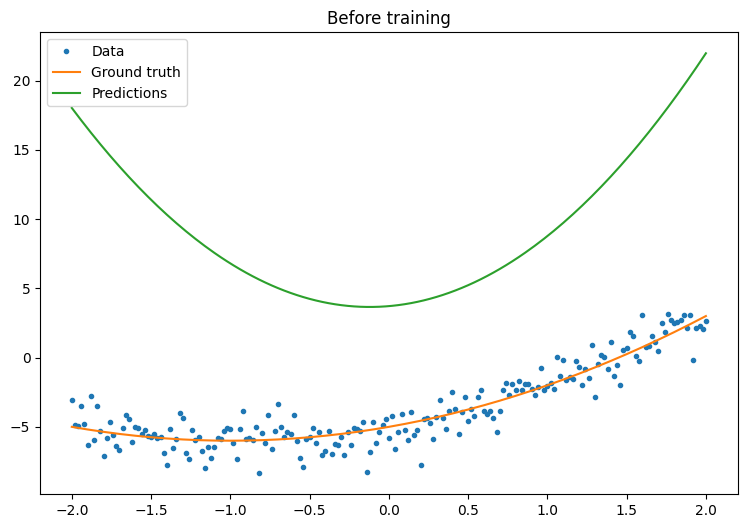

In [39]:
plot_preds(x, y, f, quad_model, 'Before training')

In [64]:
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dataset = dataset.shuffle(buffer_size=train_x.shape[0]).batch(batch_size)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [ ]:
losses = []

In [145]:
# Set training parameters
epochs = 1000000
learning_rate = 3.0

# Format training loop
for epoch in range(epochs):
    with tf.GradientTape() as tape:
      batch_loss = mlmodel.loss(mlmodel(train_x), train_y)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, mlmodel.variables)
    for g,v in zip(grads, mlmodel.variables):
        v.assign_sub(learning_rate*g)
        
    # Keep track of model loss per epoch
    loss = mlmodel.loss(mlmodel(train_x), train_y)
    losses.append(loss)
    if epoch % 100 == 0:
        print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')

Mean squared error for step 0: 0.496
Mean squared error for step 100: 0.496
Mean squared error for step 200: 0.496
Mean squared error for step 300: 0.496
Mean squared error for step 400: 0.496
Mean squared error for step 500: 0.496
Mean squared error for step 600: 0.496
Mean squared error for step 700: 0.496
Mean squared error for step 800: 0.496
Mean squared error for step 900: 0.496
Mean squared error for step 1000: 0.496
Mean squared error for step 1100: 0.496
Mean squared error for step 1200: 0.496
Mean squared error for step 1300: 0.496
Mean squared error for step 1400: 0.496
Mean squared error for step 1500: 0.496
Mean squared error for step 1600: 0.495
Mean squared error for step 1700: 0.495
Mean squared error for step 1800: 0.495
Mean squared error for step 1900: 0.495
Mean squared error for step 2000: 0.495
Mean squared error for step 2100: 0.495
Mean squared error for step 2200: 0.495
Mean squared error for step 2300: 0.495
Mean squared error for step 2400: 0.495
Mean squared

Mean squared error for step 20300: 0.495
Mean squared error for step 20400: 0.495
Mean squared error for step 20500: 0.495
Mean squared error for step 20600: 0.495
Mean squared error for step 20700: 0.495
Mean squared error for step 20800: 0.495
Mean squared error for step 20900: 0.495
Mean squared error for step 21000: 0.495
Mean squared error for step 21100: 0.495
Mean squared error for step 21200: 0.495
Mean squared error for step 21300: 0.495
Mean squared error for step 21400: 0.495
Mean squared error for step 21500: 0.495
Mean squared error for step 21600: 0.495
Mean squared error for step 21700: 0.495
Mean squared error for step 21800: 0.495
Mean squared error for step 21900: 0.495
Mean squared error for step 22000: 0.495
Mean squared error for step 22100: 0.495
Mean squared error for step 22200: 0.495
Mean squared error for step 22300: 0.495
Mean squared error for step 22400: 0.495
Mean squared error for step 22500: 0.495
Mean squared error for step 22600: 0.495
Mean squared err

Mean squared error for step 40300: 0.494
Mean squared error for step 40400: 0.494
Mean squared error for step 40500: 0.494
Mean squared error for step 40600: 0.494
Mean squared error for step 40700: 0.494
Mean squared error for step 40800: 0.494
Mean squared error for step 40900: 0.494
Mean squared error for step 41000: 0.494
Mean squared error for step 41100: 0.494
Mean squared error for step 41200: 0.494
Mean squared error for step 41300: 0.494
Mean squared error for step 41400: 0.494
Mean squared error for step 41500: 0.494
Mean squared error for step 41600: 0.494
Mean squared error for step 41700: 0.494
Mean squared error for step 41800: 0.494
Mean squared error for step 41900: 0.494
Mean squared error for step 42000: 0.494
Mean squared error for step 42100: 0.494
Mean squared error for step 42200: 0.494
Mean squared error for step 42300: 0.494
Mean squared error for step 42400: 0.494
Mean squared error for step 42500: 0.494
Mean squared error for step 42600: 0.494
Mean squared err

Mean squared error for step 60300: 0.494
Mean squared error for step 60400: 0.494
Mean squared error for step 60500: 0.494
Mean squared error for step 60600: 0.494
Mean squared error for step 60700: 0.494
Mean squared error for step 60800: 0.494
Mean squared error for step 60900: 0.494
Mean squared error for step 61000: 0.494
Mean squared error for step 61100: 0.494
Mean squared error for step 61200: 0.494
Mean squared error for step 61300: 0.494
Mean squared error for step 61400: 0.494
Mean squared error for step 61500: 0.494
Mean squared error for step 61600: 0.494
Mean squared error for step 61700: 0.494
Mean squared error for step 61800: 0.494
Mean squared error for step 61900: 0.494
Mean squared error for step 62000: 0.494
Mean squared error for step 62100: 0.494
Mean squared error for step 62200: 0.494
Mean squared error for step 62300: 0.494
Mean squared error for step 62400: 0.494
Mean squared error for step 62500: 0.494
Mean squared error for step 62600: 0.494
Mean squared err

Mean squared error for step 80300: 0.494
Mean squared error for step 80400: 0.494
Mean squared error for step 80500: 0.494
Mean squared error for step 80600: 0.494
Mean squared error for step 80700: 0.494
Mean squared error for step 80800: 0.494
Mean squared error for step 80900: 0.494
Mean squared error for step 81000: 0.494
Mean squared error for step 81100: 0.494
Mean squared error for step 81200: 0.494
Mean squared error for step 81300: 0.494
Mean squared error for step 81400: 0.494
Mean squared error for step 81500: 0.494
Mean squared error for step 81600: 0.494
Mean squared error for step 81700: 0.494
Mean squared error for step 81800: 0.494
Mean squared error for step 81900: 0.494
Mean squared error for step 82000: 0.494
Mean squared error for step 82100: 0.494
Mean squared error for step 82200: 0.494
Mean squared error for step 82300: 0.494
Mean squared error for step 82400: 0.494
Mean squared error for step 82500: 0.494
Mean squared error for step 82600: 0.494
Mean squared err

Mean squared error for step 100300: 0.493
Mean squared error for step 100400: 0.493
Mean squared error for step 100500: 0.493
Mean squared error for step 100600: 0.493
Mean squared error for step 100700: 0.493
Mean squared error for step 100800: 0.493
Mean squared error for step 100900: 0.493
Mean squared error for step 101000: 0.493
Mean squared error for step 101100: 0.493
Mean squared error for step 101200: 0.493
Mean squared error for step 101300: 0.493
Mean squared error for step 101400: 0.493
Mean squared error for step 101500: 0.493
Mean squared error for step 101600: 0.493
Mean squared error for step 101700: 0.493
Mean squared error for step 101800: 0.493
Mean squared error for step 101900: 0.493
Mean squared error for step 102000: 0.493
Mean squared error for step 102100: 0.493
Mean squared error for step 102200: 0.493
Mean squared error for step 102300: 0.493
Mean squared error for step 102400: 0.493
Mean squared error for step 102500: 0.493
Mean squared error for step 102600

Mean squared error for step 119900: 0.493
Mean squared error for step 120000: 0.493
Mean squared error for step 120100: 0.493
Mean squared error for step 120200: 0.493
Mean squared error for step 120300: 0.493
Mean squared error for step 120400: 0.493
Mean squared error for step 120500: 0.493
Mean squared error for step 120600: 0.493
Mean squared error for step 120700: 0.493
Mean squared error for step 120800: 0.493
Mean squared error for step 120900: 0.493
Mean squared error for step 121000: 0.493
Mean squared error for step 121100: 0.493
Mean squared error for step 121200: 0.493
Mean squared error for step 121300: 0.493
Mean squared error for step 121400: 0.493
Mean squared error for step 121500: 0.493
Mean squared error for step 121600: 0.493
Mean squared error for step 121700: 0.493
Mean squared error for step 121800: 0.493
Mean squared error for step 121900: 0.493
Mean squared error for step 122000: 0.493
Mean squared error for step 122100: 0.493
Mean squared error for step 122200

Mean squared error for step 139500: 0.493
Mean squared error for step 139600: 0.493
Mean squared error for step 139700: 0.493
Mean squared error for step 139800: 0.493
Mean squared error for step 139900: 0.493
Mean squared error for step 140000: 0.493
Mean squared error for step 140100: 0.493
Mean squared error for step 140200: 0.493
Mean squared error for step 140300: 0.493
Mean squared error for step 140400: 0.493
Mean squared error for step 140500: 0.493
Mean squared error for step 140600: 0.493
Mean squared error for step 140700: 0.493
Mean squared error for step 140800: 0.493
Mean squared error for step 140900: 0.493
Mean squared error for step 141000: 0.493
Mean squared error for step 141100: 0.493
Mean squared error for step 141200: 0.493
Mean squared error for step 141300: 0.493
Mean squared error for step 141400: 0.493
Mean squared error for step 141500: 0.493
Mean squared error for step 141600: 0.493
Mean squared error for step 141700: 0.493
Mean squared error for step 141800

Mean squared error for step 159100: 0.493
Mean squared error for step 159200: 0.493
Mean squared error for step 159300: 0.493
Mean squared error for step 159400: 0.493
Mean squared error for step 159500: 0.493
Mean squared error for step 159600: 0.493
Mean squared error for step 159700: 0.493
Mean squared error for step 159800: 0.493
Mean squared error for step 159900: 0.493
Mean squared error for step 160000: 0.493
Mean squared error for step 160100: 0.493
Mean squared error for step 160200: 0.493
Mean squared error for step 160300: 0.493
Mean squared error for step 160400: 0.493
Mean squared error for step 160500: 0.493
Mean squared error for step 160600: 0.493
Mean squared error for step 160700: 0.493
Mean squared error for step 160800: 0.493
Mean squared error for step 160900: 0.493
Mean squared error for step 161000: 0.493
Mean squared error for step 161100: 0.493
Mean squared error for step 161200: 0.493
Mean squared error for step 161300: 0.493
Mean squared error for step 161400

Mean squared error for step 178700: 0.493
Mean squared error for step 178800: 0.493
Mean squared error for step 178900: 0.493
Mean squared error for step 179000: 0.493
Mean squared error for step 179100: 0.493
Mean squared error for step 179200: 0.493
Mean squared error for step 179300: 0.493
Mean squared error for step 179400: 0.493
Mean squared error for step 179500: 0.493
Mean squared error for step 179600: 0.493
Mean squared error for step 179700: 0.493
Mean squared error for step 179800: 0.493
Mean squared error for step 179900: 0.493
Mean squared error for step 180000: 0.493
Mean squared error for step 180100: 0.493
Mean squared error for step 180200: 0.493
Mean squared error for step 180300: 0.492
Mean squared error for step 180400: 0.492
Mean squared error for step 180500: 0.492
Mean squared error for step 180600: 0.492
Mean squared error for step 180700: 0.492
Mean squared error for step 180800: 0.492
Mean squared error for step 180900: 0.492
Mean squared error for step 181000

Mean squared error for step 198300: 0.492
Mean squared error for step 198400: 0.492
Mean squared error for step 198500: 0.492
Mean squared error for step 198600: 0.492
Mean squared error for step 198700: 0.492
Mean squared error for step 198800: 0.492
Mean squared error for step 198900: 0.492
Mean squared error for step 199000: 0.492
Mean squared error for step 199100: 0.492
Mean squared error for step 199200: 0.492
Mean squared error for step 199300: 0.492
Mean squared error for step 199400: 0.492
Mean squared error for step 199500: 0.492
Mean squared error for step 199600: 0.492
Mean squared error for step 199700: 0.492
Mean squared error for step 199800: 0.492
Mean squared error for step 199900: 0.492
Mean squared error for step 200000: 0.492
Mean squared error for step 200100: 0.492
Mean squared error for step 200200: 0.492
Mean squared error for step 200300: 0.492
Mean squared error for step 200400: 0.492
Mean squared error for step 200500: 0.492
Mean squared error for step 200600

Mean squared error for step 217900: 0.492
Mean squared error for step 218000: 0.492
Mean squared error for step 218100: 0.492
Mean squared error for step 218200: 0.492
Mean squared error for step 218300: 0.492
Mean squared error for step 218400: 0.492
Mean squared error for step 218500: 0.492
Mean squared error for step 218600: 0.492
Mean squared error for step 218700: 0.492
Mean squared error for step 218800: 0.492
Mean squared error for step 218900: 0.492
Mean squared error for step 219000: 0.492
Mean squared error for step 219100: 0.492
Mean squared error for step 219200: 0.492
Mean squared error for step 219300: 0.492
Mean squared error for step 219400: 0.492
Mean squared error for step 219500: 0.492
Mean squared error for step 219600: 0.492
Mean squared error for step 219700: 0.492
Mean squared error for step 219800: 0.492
Mean squared error for step 219900: 0.492
Mean squared error for step 220000: 0.492
Mean squared error for step 220100: 0.492
Mean squared error for step 220200

Mean squared error for step 237500: 0.491
Mean squared error for step 237600: 0.491
Mean squared error for step 237700: 0.491
Mean squared error for step 237800: 0.491
Mean squared error for step 237900: 0.491
Mean squared error for step 238000: 0.491
Mean squared error for step 238100: 0.491
Mean squared error for step 238200: 0.491
Mean squared error for step 238300: 0.491
Mean squared error for step 238400: 0.491
Mean squared error for step 238500: 0.491
Mean squared error for step 238600: 0.491
Mean squared error for step 238700: 0.491
Mean squared error for step 238800: 0.491
Mean squared error for step 238900: 0.491
Mean squared error for step 239000: 0.491
Mean squared error for step 239100: 0.491
Mean squared error for step 239200: 0.491
Mean squared error for step 239300: 0.491
Mean squared error for step 239400: 0.491
Mean squared error for step 239500: 0.491
Mean squared error for step 239600: 0.491
Mean squared error for step 239700: 0.491
Mean squared error for step 239800

Mean squared error for step 257100: 0.490
Mean squared error for step 257200: 0.490
Mean squared error for step 257300: 0.490
Mean squared error for step 257400: 0.490
Mean squared error for step 257500: 0.490
Mean squared error for step 257600: 0.490
Mean squared error for step 257700: 0.490
Mean squared error for step 257800: 0.490
Mean squared error for step 257900: 0.490
Mean squared error for step 258000: 0.490
Mean squared error for step 258100: 0.490
Mean squared error for step 258200: 0.490
Mean squared error for step 258300: 0.490
Mean squared error for step 258400: 0.490
Mean squared error for step 258500: 0.490
Mean squared error for step 258600: 0.490
Mean squared error for step 258700: 0.490
Mean squared error for step 258800: 0.490
Mean squared error for step 258900: 0.490
Mean squared error for step 259000: 0.490
Mean squared error for step 259100: 0.490
Mean squared error for step 259200: 0.490
Mean squared error for step 259300: 0.490
Mean squared error for step 259400

Mean squared error for step 276700: 0.490
Mean squared error for step 276800: 0.490
Mean squared error for step 276900: 0.490
Mean squared error for step 277000: 0.490
Mean squared error for step 277100: 0.490
Mean squared error for step 277200: 0.490
Mean squared error for step 277300: 0.490
Mean squared error for step 277400: 0.490
Mean squared error for step 277500: 0.490
Mean squared error for step 277600: 0.490
Mean squared error for step 277700: 0.490
Mean squared error for step 277800: 0.490
Mean squared error for step 277900: 0.490
Mean squared error for step 278000: 0.490
Mean squared error for step 278100: 0.490
Mean squared error for step 278200: 0.490
Mean squared error for step 278300: 0.490
Mean squared error for step 278400: 0.490
Mean squared error for step 278500: 0.490
Mean squared error for step 278600: 0.490
Mean squared error for step 278700: 0.490
Mean squared error for step 278800: 0.490
Mean squared error for step 278900: 0.490
Mean squared error for step 279000

Mean squared error for step 296300: 0.490
Mean squared error for step 296400: 0.490
Mean squared error for step 296500: 0.490
Mean squared error for step 296600: 0.490
Mean squared error for step 296700: 0.490
Mean squared error for step 296800: 0.490
Mean squared error for step 296900: 0.490
Mean squared error for step 297000: 0.490
Mean squared error for step 297100: 0.490
Mean squared error for step 297200: 0.490
Mean squared error for step 297300: 0.490
Mean squared error for step 297400: 0.490
Mean squared error for step 297500: 0.490
Mean squared error for step 297600: 0.490
Mean squared error for step 297700: 0.490
Mean squared error for step 297800: 0.490
Mean squared error for step 297900: 0.490
Mean squared error for step 298000: 0.490
Mean squared error for step 298100: 0.490
Mean squared error for step 298200: 0.490
Mean squared error for step 298300: 0.490
Mean squared error for step 298400: 0.490
Mean squared error for step 298500: 0.490
Mean squared error for step 298600

Mean squared error for step 315900: 0.489
Mean squared error for step 316000: 0.489
Mean squared error for step 316100: 0.489
Mean squared error for step 316200: 0.489
Mean squared error for step 316300: 0.489
Mean squared error for step 316400: 0.489
Mean squared error for step 316500: 0.489
Mean squared error for step 316600: 0.489
Mean squared error for step 316700: 0.489
Mean squared error for step 316800: 0.489
Mean squared error for step 316900: 0.489
Mean squared error for step 317000: 0.489
Mean squared error for step 317100: 0.489
Mean squared error for step 317200: 0.489
Mean squared error for step 317300: 0.489
Mean squared error for step 317400: 0.489
Mean squared error for step 317500: 0.489
Mean squared error for step 317600: 0.489
Mean squared error for step 317700: 0.489
Mean squared error for step 317800: 0.489
Mean squared error for step 317900: 0.489
Mean squared error for step 318000: 0.489
Mean squared error for step 318100: 0.489
Mean squared error for step 318200

Mean squared error for step 335500: 0.489
Mean squared error for step 335600: 0.489
Mean squared error for step 335700: 0.489
Mean squared error for step 335800: 0.489
Mean squared error for step 335900: 0.489
Mean squared error for step 336000: 0.489
Mean squared error for step 336100: 0.489
Mean squared error for step 336200: 0.489
Mean squared error for step 336300: 0.489
Mean squared error for step 336400: 0.489
Mean squared error for step 336500: 0.489
Mean squared error for step 336600: 0.489
Mean squared error for step 336700: 0.489
Mean squared error for step 336800: 0.489
Mean squared error for step 336900: 0.489
Mean squared error for step 337000: 0.489
Mean squared error for step 337100: 0.489
Mean squared error for step 337200: 0.489
Mean squared error for step 337300: 0.489
Mean squared error for step 337400: 0.489
Mean squared error for step 337500: 0.489
Mean squared error for step 337600: 0.489
Mean squared error for step 337700: 0.489
Mean squared error for step 337800

Mean squared error for step 355100: 0.489
Mean squared error for step 355200: 0.489
Mean squared error for step 355300: 0.489
Mean squared error for step 355400: 0.489
Mean squared error for step 355500: 0.489
Mean squared error for step 355600: 0.489
Mean squared error for step 355700: 0.489
Mean squared error for step 355800: 0.489
Mean squared error for step 355900: 0.489
Mean squared error for step 356000: 0.489
Mean squared error for step 356100: 0.489
Mean squared error for step 356200: 0.489
Mean squared error for step 356300: 0.489
Mean squared error for step 356400: 0.489
Mean squared error for step 356500: 0.489
Mean squared error for step 356600: 0.489
Mean squared error for step 356700: 0.489
Mean squared error for step 356800: 0.489
Mean squared error for step 356900: 0.489
Mean squared error for step 357000: 0.489
Mean squared error for step 357100: 0.489
Mean squared error for step 357200: 0.489
Mean squared error for step 357300: 0.489
Mean squared error for step 357400

Mean squared error for step 374700: 0.489
Mean squared error for step 374800: 0.489
Mean squared error for step 374900: 0.489
Mean squared error for step 375000: 0.489
Mean squared error for step 375100: 0.489
Mean squared error for step 375200: 0.489
Mean squared error for step 375300: 0.489
Mean squared error for step 375400: 0.489
Mean squared error for step 375500: 0.489
Mean squared error for step 375600: 0.489
Mean squared error for step 375700: 0.489
Mean squared error for step 375800: 0.489
Mean squared error for step 375900: 0.489
Mean squared error for step 376000: 0.489
Mean squared error for step 376100: 0.489
Mean squared error for step 376200: 0.489
Mean squared error for step 376300: 0.489
Mean squared error for step 376400: 0.489
Mean squared error for step 376500: 0.489
Mean squared error for step 376600: 0.489
Mean squared error for step 376700: 0.489
Mean squared error for step 376800: 0.489
Mean squared error for step 376900: 0.489
Mean squared error for step 377000

Mean squared error for step 394300: 0.489
Mean squared error for step 394400: 0.489
Mean squared error for step 394500: 0.489
Mean squared error for step 394600: 0.489
Mean squared error for step 394700: 0.489
Mean squared error for step 394800: 0.489
Mean squared error for step 394900: 0.489
Mean squared error for step 395000: 0.489
Mean squared error for step 395100: 0.489
Mean squared error for step 395200: 0.489
Mean squared error for step 395300: 0.489
Mean squared error for step 395400: 0.489
Mean squared error for step 395500: 0.489
Mean squared error for step 395600: 0.489
Mean squared error for step 395700: 0.489
Mean squared error for step 395800: 0.489
Mean squared error for step 395900: 0.489
Mean squared error for step 396000: 0.489
Mean squared error for step 396100: 0.489
Mean squared error for step 396200: 0.489
Mean squared error for step 396300: 0.489
Mean squared error for step 396400: 0.489
Mean squared error for step 396500: 0.489
Mean squared error for step 396600

Mean squared error for step 413900: 0.489
Mean squared error for step 414000: 0.489
Mean squared error for step 414100: 0.489
Mean squared error for step 414200: 0.489
Mean squared error for step 414300: 0.489
Mean squared error for step 414400: 0.489
Mean squared error for step 414500: 0.489
Mean squared error for step 414600: 0.489
Mean squared error for step 414700: 0.489
Mean squared error for step 414800: 0.489
Mean squared error for step 414900: 0.489
Mean squared error for step 415000: 0.489
Mean squared error for step 415100: 0.489
Mean squared error for step 415200: 0.489
Mean squared error for step 415300: 0.489
Mean squared error for step 415400: 0.489
Mean squared error for step 415500: 0.489
Mean squared error for step 415600: 0.489
Mean squared error for step 415700: 0.489
Mean squared error for step 415800: 0.489
Mean squared error for step 415900: 0.489
Mean squared error for step 416000: 0.489
Mean squared error for step 416100: 0.489
Mean squared error for step 416200

Mean squared error for step 433500: 0.489
Mean squared error for step 433600: 0.489
Mean squared error for step 433700: 0.489
Mean squared error for step 433800: 0.489
Mean squared error for step 433900: 0.489
Mean squared error for step 434000: 0.489
Mean squared error for step 434100: 0.489
Mean squared error for step 434200: 0.489
Mean squared error for step 434300: 0.489
Mean squared error for step 434400: 0.489
Mean squared error for step 434500: 0.489
Mean squared error for step 434600: 0.489
Mean squared error for step 434700: 0.489
Mean squared error for step 434800: 0.489
Mean squared error for step 434900: 0.489
Mean squared error for step 435000: 0.489
Mean squared error for step 435100: 0.489
Mean squared error for step 435200: 0.489
Mean squared error for step 435300: 0.489
Mean squared error for step 435400: 0.489
Mean squared error for step 435500: 0.489
Mean squared error for step 435600: 0.489
Mean squared error for step 435700: 0.489
Mean squared error for step 435800

Mean squared error for step 453100: 0.488
Mean squared error for step 453200: 0.488
Mean squared error for step 453300: 0.488
Mean squared error for step 453400: 0.488
Mean squared error for step 453500: 0.488
Mean squared error for step 453600: 0.488
Mean squared error for step 453700: 0.488
Mean squared error for step 453800: 0.488
Mean squared error for step 453900: 0.488
Mean squared error for step 454000: 0.488
Mean squared error for step 454100: 0.488
Mean squared error for step 454200: 0.488
Mean squared error for step 454300: 0.488
Mean squared error for step 454400: 0.488
Mean squared error for step 454500: 0.488
Mean squared error for step 454600: 0.488
Mean squared error for step 454700: 0.488
Mean squared error for step 454800: 0.488
Mean squared error for step 454900: 0.488
Mean squared error for step 455000: 0.488
Mean squared error for step 455100: 0.488
Mean squared error for step 455200: 0.488
Mean squared error for step 455300: 0.488
Mean squared error for step 455400

Mean squared error for step 472700: 0.488
Mean squared error for step 472800: 0.488
Mean squared error for step 472900: 0.488
Mean squared error for step 473000: 0.488
Mean squared error for step 473100: 0.488
Mean squared error for step 473200: 0.488
Mean squared error for step 473300: 0.488
Mean squared error for step 473400: 0.488
Mean squared error for step 473500: 0.488
Mean squared error for step 473600: 0.488
Mean squared error for step 473700: 0.488
Mean squared error for step 473800: 0.488
Mean squared error for step 473900: 0.488
Mean squared error for step 474000: 0.488
Mean squared error for step 474100: 0.488
Mean squared error for step 474200: 0.488
Mean squared error for step 474300: 0.488
Mean squared error for step 474400: 0.488
Mean squared error for step 474500: 0.488
Mean squared error for step 474600: 0.488
Mean squared error for step 474700: 0.488
Mean squared error for step 474800: 0.488
Mean squared error for step 474900: 0.488
Mean squared error for step 475000

Mean squared error for step 492300: 0.488
Mean squared error for step 492400: 0.488
Mean squared error for step 492500: 0.488
Mean squared error for step 492600: 0.488
Mean squared error for step 492700: 0.488
Mean squared error for step 492800: 0.488
Mean squared error for step 492900: 0.488
Mean squared error for step 493000: 0.488
Mean squared error for step 493100: 0.488
Mean squared error for step 493200: 0.488
Mean squared error for step 493300: 0.488
Mean squared error for step 493400: 0.488
Mean squared error for step 493500: 0.488
Mean squared error for step 493600: 0.488
Mean squared error for step 493700: 0.488
Mean squared error for step 493800: 0.488
Mean squared error for step 493900: 0.488
Mean squared error for step 494000: 0.488
Mean squared error for step 494100: 0.488
Mean squared error for step 494200: 0.488
Mean squared error for step 494300: 0.488
Mean squared error for step 494400: 0.488
Mean squared error for step 494500: 0.488
Mean squared error for step 494600

Mean squared error for step 511900: 0.488
Mean squared error for step 512000: 0.488
Mean squared error for step 512100: 0.488
Mean squared error for step 512200: 0.488
Mean squared error for step 512300: 0.488
Mean squared error for step 512400: 0.488
Mean squared error for step 512500: 0.488
Mean squared error for step 512600: 0.488
Mean squared error for step 512700: 0.488
Mean squared error for step 512800: 0.488
Mean squared error for step 512900: 0.488
Mean squared error for step 513000: 0.488
Mean squared error for step 513100: 0.488
Mean squared error for step 513200: 0.488
Mean squared error for step 513300: 0.488
Mean squared error for step 513400: 0.488
Mean squared error for step 513500: 0.488
Mean squared error for step 513600: 0.488
Mean squared error for step 513700: 0.488
Mean squared error for step 513800: 0.488
Mean squared error for step 513900: 0.488
Mean squared error for step 514000: 0.488
Mean squared error for step 514100: 0.488
Mean squared error for step 514200

Mean squared error for step 531500: 0.488
Mean squared error for step 531600: 0.488
Mean squared error for step 531700: 0.488
Mean squared error for step 531800: 0.488
Mean squared error for step 531900: 0.488
Mean squared error for step 532000: 0.488
Mean squared error for step 532100: 0.488
Mean squared error for step 532200: 0.488
Mean squared error for step 532300: 0.488
Mean squared error for step 532400: 0.488
Mean squared error for step 532500: 0.488
Mean squared error for step 532600: 0.488
Mean squared error for step 532700: 0.488
Mean squared error for step 532800: 0.488
Mean squared error for step 532900: 0.488
Mean squared error for step 533000: 0.488
Mean squared error for step 533100: 0.488
Mean squared error for step 533200: 0.488
Mean squared error for step 533300: 0.488
Mean squared error for step 533400: 0.488
Mean squared error for step 533500: 0.488
Mean squared error for step 533600: 0.488
Mean squared error for step 533700: 0.488
Mean squared error for step 533800

Mean squared error for step 551100: 0.488
Mean squared error for step 551200: 0.488
Mean squared error for step 551300: 0.488
Mean squared error for step 551400: 0.488
Mean squared error for step 551500: 0.488
Mean squared error for step 551600: 0.488
Mean squared error for step 551700: 0.488
Mean squared error for step 551800: 0.488
Mean squared error for step 551900: 0.488
Mean squared error for step 552000: 0.488
Mean squared error for step 552100: 0.488
Mean squared error for step 552200: 0.488
Mean squared error for step 552300: 0.488
Mean squared error for step 552400: 0.488
Mean squared error for step 552500: 0.488
Mean squared error for step 552600: 0.488
Mean squared error for step 552700: 0.488
Mean squared error for step 552800: 0.488
Mean squared error for step 552900: 0.488
Mean squared error for step 553000: 0.488
Mean squared error for step 553100: 0.488
Mean squared error for step 553200: 0.488
Mean squared error for step 553300: 0.488
Mean squared error for step 553400

Mean squared error for step 570700: 0.488
Mean squared error for step 570800: 0.488
Mean squared error for step 570900: 0.488
Mean squared error for step 571000: 0.488
Mean squared error for step 571100: 0.488
Mean squared error for step 571200: 0.488
Mean squared error for step 571300: 0.488
Mean squared error for step 571400: 0.488
Mean squared error for step 571500: 0.488
Mean squared error for step 571600: 0.488
Mean squared error for step 571700: 0.488
Mean squared error for step 571800: 0.488
Mean squared error for step 571900: 0.488
Mean squared error for step 572000: 0.488
Mean squared error for step 572100: 0.488
Mean squared error for step 572200: 0.488
Mean squared error for step 572300: 0.488
Mean squared error for step 572400: 0.488
Mean squared error for step 572500: 0.488
Mean squared error for step 572600: 0.488
Mean squared error for step 572700: 0.488
Mean squared error for step 572800: 0.488
Mean squared error for step 572900: 0.488
Mean squared error for step 573000

Mean squared error for step 590300: 0.488
Mean squared error for step 590400: 0.488
Mean squared error for step 590500: 0.488
Mean squared error for step 590600: 0.488
Mean squared error for step 590700: 0.488
Mean squared error for step 590800: 0.488
Mean squared error for step 590900: 0.487
Mean squared error for step 591000: 0.487
Mean squared error for step 591100: 0.487
Mean squared error for step 591200: 0.487
Mean squared error for step 591300: 0.487
Mean squared error for step 591400: 0.487
Mean squared error for step 591500: 0.487
Mean squared error for step 591600: 0.487
Mean squared error for step 591700: 0.487
Mean squared error for step 591800: 0.487
Mean squared error for step 591900: 0.487
Mean squared error for step 592000: 0.487
Mean squared error for step 592100: 0.487
Mean squared error for step 592200: 0.487
Mean squared error for step 592300: 0.487
Mean squared error for step 592400: 0.487
Mean squared error for step 592500: 0.487
Mean squared error for step 592600

Mean squared error for step 609900: 0.487
Mean squared error for step 610000: 0.487
Mean squared error for step 610100: 0.487
Mean squared error for step 610200: 0.487
Mean squared error for step 610300: 0.487
Mean squared error for step 610400: 0.487
Mean squared error for step 610500: 0.487
Mean squared error for step 610600: 0.487
Mean squared error for step 610700: 0.487
Mean squared error for step 610800: 0.487
Mean squared error for step 610900: 0.487
Mean squared error for step 611000: 0.487
Mean squared error for step 611100: 0.487
Mean squared error for step 611200: 0.487
Mean squared error for step 611300: 0.487
Mean squared error for step 611400: 0.487
Mean squared error for step 611500: 0.487
Mean squared error for step 611600: 0.487
Mean squared error for step 611700: 0.487
Mean squared error for step 611800: 0.487
Mean squared error for step 611900: 0.487
Mean squared error for step 612000: 0.487
Mean squared error for step 612100: 0.487
Mean squared error for step 612200

Mean squared error for step 629500: 0.487
Mean squared error for step 629600: 0.487
Mean squared error for step 629700: 0.487
Mean squared error for step 629800: 0.487
Mean squared error for step 629900: 0.487
Mean squared error for step 630000: 0.487
Mean squared error for step 630100: 0.487
Mean squared error for step 630200: 0.487
Mean squared error for step 630300: 0.487
Mean squared error for step 630400: 0.487
Mean squared error for step 630500: 0.487
Mean squared error for step 630600: 0.487
Mean squared error for step 630700: 0.487
Mean squared error for step 630800: 0.487
Mean squared error for step 630900: 0.487
Mean squared error for step 631000: 0.487
Mean squared error for step 631100: 0.487
Mean squared error for step 631200: 0.487
Mean squared error for step 631300: 0.487
Mean squared error for step 631400: 0.487
Mean squared error for step 631500: 0.487
Mean squared error for step 631600: 0.487
Mean squared error for step 631700: 0.487
Mean squared error for step 631800

Mean squared error for step 649100: 0.487
Mean squared error for step 649200: 0.487
Mean squared error for step 649300: 0.487
Mean squared error for step 649400: 0.487
Mean squared error for step 649500: 0.487
Mean squared error for step 649600: 0.487
Mean squared error for step 649700: 0.487
Mean squared error for step 649800: 0.487
Mean squared error for step 649900: 0.487
Mean squared error for step 650000: 0.487
Mean squared error for step 650100: 0.487
Mean squared error for step 650200: 0.487
Mean squared error for step 650300: 0.487
Mean squared error for step 650400: 0.487
Mean squared error for step 650500: 0.487
Mean squared error for step 650600: 0.487
Mean squared error for step 650700: 0.487
Mean squared error for step 650800: 0.487
Mean squared error for step 650900: 0.487
Mean squared error for step 651000: 0.487
Mean squared error for step 651100: 0.487
Mean squared error for step 651200: 0.487
Mean squared error for step 651300: 0.487
Mean squared error for step 651400

Mean squared error for step 668700: 0.487
Mean squared error for step 668800: 0.487
Mean squared error for step 668900: 0.487
Mean squared error for step 669000: 0.487
Mean squared error for step 669100: 0.487
Mean squared error for step 669200: 0.487
Mean squared error for step 669300: 0.487
Mean squared error for step 669400: 0.487
Mean squared error for step 669500: 0.487
Mean squared error for step 669600: 0.487
Mean squared error for step 669700: 0.487
Mean squared error for step 669800: 0.487
Mean squared error for step 669900: 0.487
Mean squared error for step 670000: 0.487
Mean squared error for step 670100: 0.487
Mean squared error for step 670200: 0.487
Mean squared error for step 670300: 0.487
Mean squared error for step 670400: 0.487
Mean squared error for step 670500: 0.487
Mean squared error for step 670600: 0.487
Mean squared error for step 670700: 0.487
Mean squared error for step 670800: 0.487
Mean squared error for step 670900: 0.487
Mean squared error for step 671000

Mean squared error for step 688300: 0.487
Mean squared error for step 688400: 0.487
Mean squared error for step 688500: 0.487
Mean squared error for step 688600: 0.487
Mean squared error for step 688700: 0.487
Mean squared error for step 688800: 0.487
Mean squared error for step 688900: 0.487
Mean squared error for step 689000: 0.487
Mean squared error for step 689100: 0.487
Mean squared error for step 689200: 0.487
Mean squared error for step 689300: 0.487
Mean squared error for step 689400: 0.487
Mean squared error for step 689500: 0.487
Mean squared error for step 689600: 0.487
Mean squared error for step 689700: 0.487
Mean squared error for step 689800: 0.487
Mean squared error for step 689900: 0.487
Mean squared error for step 690000: 0.487
Mean squared error for step 690100: 0.487
Mean squared error for step 690200: 0.487
Mean squared error for step 690300: 0.487
Mean squared error for step 690400: 0.487
Mean squared error for step 690500: 0.487
Mean squared error for step 690600

Mean squared error for step 707900: 0.486
Mean squared error for step 708000: 0.486
Mean squared error for step 708100: 0.486
Mean squared error for step 708200: 0.486
Mean squared error for step 708300: 0.486
Mean squared error for step 708400: 0.486
Mean squared error for step 708500: 0.487
Mean squared error for step 708600: 0.486
Mean squared error for step 708700: 0.486
Mean squared error for step 708800: 0.486
Mean squared error for step 708900: 0.486
Mean squared error for step 709000: 0.486
Mean squared error for step 709100: 0.487
Mean squared error for step 709200: 0.486
Mean squared error for step 709300: 0.486
Mean squared error for step 709400: 0.486
Mean squared error for step 709500: 0.486
Mean squared error for step 709600: 0.486
Mean squared error for step 709700: 0.486
Mean squared error for step 709800: 0.486
Mean squared error for step 709900: 0.486
Mean squared error for step 710000: 0.486
Mean squared error for step 710100: 0.486
Mean squared error for step 710200

Mean squared error for step 727500: 0.485
Mean squared error for step 727600: 0.485
Mean squared error for step 727700: 0.485
Mean squared error for step 727800: 0.485
Mean squared error for step 727900: 0.485
Mean squared error for step 728000: 0.485
Mean squared error for step 728100: 0.485
Mean squared error for step 728200: 0.485
Mean squared error for step 728300: 0.485
Mean squared error for step 728400: 0.485
Mean squared error for step 728500: 0.485
Mean squared error for step 728600: 0.485
Mean squared error for step 728700: 0.485
Mean squared error for step 728800: 0.485
Mean squared error for step 728900: 0.485
Mean squared error for step 729000: 0.485
Mean squared error for step 729100: 0.485
Mean squared error for step 729200: 0.485
Mean squared error for step 729300: 0.485
Mean squared error for step 729400: 0.487
Mean squared error for step 729500: 0.485
Mean squared error for step 729600: 0.485
Mean squared error for step 729700: 0.485
Mean squared error for step 729800

Mean squared error for step 747100: 0.484
Mean squared error for step 747200: 0.484
Mean squared error for step 747300: 0.484
Mean squared error for step 747400: 0.484
Mean squared error for step 747500: 0.484
Mean squared error for step 747600: 0.484
Mean squared error for step 747700: 0.484
Mean squared error for step 747800: 0.484
Mean squared error for step 747900: 0.484
Mean squared error for step 748000: 0.484
Mean squared error for step 748100: 0.484
Mean squared error for step 748200: 0.484
Mean squared error for step 748300: 0.484
Mean squared error for step 748400: 0.484
Mean squared error for step 748500: 0.484
Mean squared error for step 748600: 0.484
Mean squared error for step 748700: 0.484
Mean squared error for step 748800: 0.484
Mean squared error for step 748900: 0.484
Mean squared error for step 749000: 0.484
Mean squared error for step 749100: 0.484
Mean squared error for step 749200: 0.484
Mean squared error for step 749300: 0.484
Mean squared error for step 749400

Mean squared error for step 766700: 0.484
Mean squared error for step 766800: 0.484
Mean squared error for step 766900: 0.484
Mean squared error for step 767000: 0.484
Mean squared error for step 767100: 0.484
Mean squared error for step 767200: 0.484
Mean squared error for step 767300: 0.484
Mean squared error for step 767400: 0.484
Mean squared error for step 767500: 0.484
Mean squared error for step 767600: 0.484
Mean squared error for step 767700: 0.484
Mean squared error for step 767800: 0.484
Mean squared error for step 767900: 0.484
Mean squared error for step 768000: 0.484
Mean squared error for step 768100: 0.484
Mean squared error for step 768200: 0.491
Mean squared error for step 768300: 0.483
Mean squared error for step 768400: 0.483
Mean squared error for step 768500: 0.483
Mean squared error for step 768600: 0.483
Mean squared error for step 768700: 0.483
Mean squared error for step 768800: 0.483
Mean squared error for step 768900: 0.483
Mean squared error for step 769000

Mean squared error for step 786300: 0.483
Mean squared error for step 786400: 0.483
Mean squared error for step 786500: 0.483
Mean squared error for step 786600: 0.483
Mean squared error for step 786700: 0.483
Mean squared error for step 786800: 0.483
Mean squared error for step 786900: 0.483
Mean squared error for step 787000: 0.483
Mean squared error for step 787100: 0.483
Mean squared error for step 787200: 0.483
Mean squared error for step 787300: 0.483
Mean squared error for step 787400: 0.483
Mean squared error for step 787500: 0.483
Mean squared error for step 787600: 0.483
Mean squared error for step 787700: 0.483
Mean squared error for step 787800: 0.483
Mean squared error for step 787900: 0.483
Mean squared error for step 788000: 0.483
Mean squared error for step 788100: 0.483
Mean squared error for step 788200: 0.495
Mean squared error for step 788300: 0.483
Mean squared error for step 788400: 0.483
Mean squared error for step 788500: 0.483
Mean squared error for step 788600

Mean squared error for step 805900: 0.483
Mean squared error for step 806000: 0.483
Mean squared error for step 806100: 0.483
Mean squared error for step 806200: 0.483
Mean squared error for step 806300: 0.483
Mean squared error for step 806400: 0.483
Mean squared error for step 806500: 0.483
Mean squared error for step 806600: 0.483
Mean squared error for step 806700: 0.483
Mean squared error for step 806800: 0.483
Mean squared error for step 806900: 0.483
Mean squared error for step 807000: 0.483
Mean squared error for step 807100: 0.483
Mean squared error for step 807200: 0.483
Mean squared error for step 807300: 0.483
Mean squared error for step 807400: 0.483
Mean squared error for step 807500: 0.483
Mean squared error for step 807600: 0.483
Mean squared error for step 807700: 0.483
Mean squared error for step 807800: 0.483
Mean squared error for step 807900: 0.483
Mean squared error for step 808000: 0.483
Mean squared error for step 808100: 0.483
Mean squared error for step 808200

Mean squared error for step 825500: 0.483
Mean squared error for step 825600: 0.483
Mean squared error for step 825700: 0.483
Mean squared error for step 825800: 0.483
Mean squared error for step 825900: 0.483
Mean squared error for step 826000: 0.483
Mean squared error for step 826100: 0.483
Mean squared error for step 826200: 0.483
Mean squared error for step 826300: 0.483
Mean squared error for step 826400: 0.483
Mean squared error for step 826500: 0.483
Mean squared error for step 826600: 0.483
Mean squared error for step 826700: 0.483
Mean squared error for step 826800: 0.483
Mean squared error for step 826900: 0.483
Mean squared error for step 827000: 0.483
Mean squared error for step 827100: 0.483
Mean squared error for step 827200: 0.483
Mean squared error for step 827300: 0.483
Mean squared error for step 827400: 0.483
Mean squared error for step 827500: 0.483
Mean squared error for step 827600: 0.483
Mean squared error for step 827700: 0.483
Mean squared error for step 827800

Mean squared error for step 845100: 0.483
Mean squared error for step 845200: 0.483
Mean squared error for step 845300: 0.483
Mean squared error for step 845400: 0.483
Mean squared error for step 845500: 0.483
Mean squared error for step 845600: 0.483
Mean squared error for step 845700: 0.483
Mean squared error for step 845800: 0.483
Mean squared error for step 845900: 0.483
Mean squared error for step 846000: 0.483
Mean squared error for step 846100: 0.483
Mean squared error for step 846200: 0.483
Mean squared error for step 846300: 0.483
Mean squared error for step 846400: 0.483
Mean squared error for step 846500: 0.483
Mean squared error for step 846600: 0.483
Mean squared error for step 846700: 0.483
Mean squared error for step 846800: 0.483
Mean squared error for step 846900: 0.483
Mean squared error for step 847000: 0.483
Mean squared error for step 847100: 0.483
Mean squared error for step 847200: 0.483
Mean squared error for step 847300: 0.483
Mean squared error for step 847400

Mean squared error for step 864700: 0.483
Mean squared error for step 864800: 0.483
Mean squared error for step 864900: 0.483
Mean squared error for step 865000: 0.483
Mean squared error for step 865100: 0.483
Mean squared error for step 865200: 0.483
Mean squared error for step 865300: 0.483
Mean squared error for step 865400: 0.483
Mean squared error for step 865500: 0.483
Mean squared error for step 865600: 0.483
Mean squared error for step 865700: 0.483
Mean squared error for step 865800: 0.483
Mean squared error for step 865900: 0.483
Mean squared error for step 866000: 0.483
Mean squared error for step 866100: 0.483
Mean squared error for step 866200: 0.483
Mean squared error for step 866300: 0.483
Mean squared error for step 866400: 0.483
Mean squared error for step 866500: 0.483
Mean squared error for step 866600: 0.483
Mean squared error for step 866700: 0.483
Mean squared error for step 866800: 0.483
Mean squared error for step 866900: 0.483
Mean squared error for step 867000

Mean squared error for step 884300: 0.482
Mean squared error for step 884400: 0.482
Mean squared error for step 884500: 0.482
Mean squared error for step 884600: 0.482
Mean squared error for step 884700: 0.482
Mean squared error for step 884800: 0.482
Mean squared error for step 884900: 0.482
Mean squared error for step 885000: 0.482
Mean squared error for step 885100: 0.482
Mean squared error for step 885200: 0.482
Mean squared error for step 885300: 0.482
Mean squared error for step 885400: 0.482
Mean squared error for step 885500: 0.482
Mean squared error for step 885600: 0.482
Mean squared error for step 885700: 0.482
Mean squared error for step 885800: 0.482
Mean squared error for step 885900: 0.482
Mean squared error for step 886000: 0.482
Mean squared error for step 886100: 0.482
Mean squared error for step 886200: 0.482
Mean squared error for step 886300: 0.482
Mean squared error for step 886400: 0.482
Mean squared error for step 886500: 0.482
Mean squared error for step 886600

Mean squared error for step 903900: 0.482
Mean squared error for step 904000: 0.482
Mean squared error for step 904100: 0.482
Mean squared error for step 904200: 0.482
Mean squared error for step 904300: 0.482
Mean squared error for step 904400: 0.482
Mean squared error for step 904500: 0.482
Mean squared error for step 904600: 0.482
Mean squared error for step 904700: 0.482
Mean squared error for step 904800: 0.482
Mean squared error for step 904900: 0.482
Mean squared error for step 905000: 0.482
Mean squared error for step 905100: 0.482
Mean squared error for step 905200: 0.482
Mean squared error for step 905300: 0.482
Mean squared error for step 905400: 0.482
Mean squared error for step 905500: 0.482
Mean squared error for step 905600: 0.482
Mean squared error for step 905700: 0.482
Mean squared error for step 905800: 0.482
Mean squared error for step 905900: 0.482
Mean squared error for step 906000: 0.482
Mean squared error for step 906100: 0.482
Mean squared error for step 906200

Mean squared error for step 923500: 0.482
Mean squared error for step 923600: 0.482
Mean squared error for step 923700: 0.482
Mean squared error for step 923800: 0.482
Mean squared error for step 923900: 0.482
Mean squared error for step 924000: 0.482
Mean squared error for step 924100: 0.482
Mean squared error for step 924200: 0.482
Mean squared error for step 924300: 0.482
Mean squared error for step 924400: 0.482
Mean squared error for step 924500: 0.482
Mean squared error for step 924600: 0.482
Mean squared error for step 924700: 0.482
Mean squared error for step 924800: 0.482
Mean squared error for step 924900: 0.482
Mean squared error for step 925000: 0.482
Mean squared error for step 925100: 0.482
Mean squared error for step 925200: 0.482
Mean squared error for step 925300: 0.482
Mean squared error for step 925400: 0.482
Mean squared error for step 925500: 0.492
Mean squared error for step 925600: 0.482
Mean squared error for step 925700: 0.482
Mean squared error for step 925800

Mean squared error for step 943100: 0.482
Mean squared error for step 943200: 0.482
Mean squared error for step 943300: 0.482
Mean squared error for step 943400: 0.482
Mean squared error for step 943500: 0.482
Mean squared error for step 943600: 0.482
Mean squared error for step 943700: 0.482
Mean squared error for step 943800: 0.482
Mean squared error for step 943900: 0.482
Mean squared error for step 944000: 0.482
Mean squared error for step 944100: 0.482
Mean squared error for step 944200: 0.482
Mean squared error for step 944300: 0.482
Mean squared error for step 944400: 0.482
Mean squared error for step 944500: 0.482
Mean squared error for step 944600: 0.482
Mean squared error for step 944700: 0.482
Mean squared error for step 944800: 0.495
Mean squared error for step 944900: 0.482
Mean squared error for step 945000: 0.482
Mean squared error for step 945100: 0.482
Mean squared error for step 945200: 0.482
Mean squared error for step 945300: 0.482
Mean squared error for step 945400

Mean squared error for step 962700: 0.481
Mean squared error for step 962800: 0.481
Mean squared error for step 962900: 0.481
Mean squared error for step 963000: 0.482
Mean squared error for step 963100: 0.491
Mean squared error for step 963200: 0.481
Mean squared error for step 963300: 0.481
Mean squared error for step 963400: 0.481
Mean squared error for step 963500: 0.481
Mean squared error for step 963600: 0.481
Mean squared error for step 963700: 0.482
Mean squared error for step 963800: 0.482
Mean squared error for step 963900: 0.482
Mean squared error for step 964000: 0.482
Mean squared error for step 964100: 0.482
Mean squared error for step 964200: 0.482
Mean squared error for step 964300: 0.482
Mean squared error for step 964400: 0.482
Mean squared error for step 964500: 0.482
Mean squared error for step 964600: 0.482
Mean squared error for step 964700: 0.482
Mean squared error for step 964800: 0.482
Mean squared error for step 964900: 0.482
Mean squared error for step 965000

Mean squared error for step 982300: 0.481
Mean squared error for step 982400: 0.481
Mean squared error for step 982500: 0.481
Mean squared error for step 982600: 0.481
Mean squared error for step 982700: 0.481
Mean squared error for step 982800: 0.481
Mean squared error for step 982900: 0.481
Mean squared error for step 983000: 0.481
Mean squared error for step 983100: 0.481
Mean squared error for step 983200: 0.481
Mean squared error for step 983300: 0.481
Mean squared error for step 983400: 0.481
Mean squared error for step 983500: 0.481
Mean squared error for step 983600: 0.481
Mean squared error for step 983700: 0.481
Mean squared error for step 983800: 0.481
Mean squared error for step 983900: 0.481
Mean squared error for step 984000: 0.481
Mean squared error for step 984100: 0.481
Mean squared error for step 984200: 0.481
Mean squared error for step 984300: 0.481
Mean squared error for step 984400: 0.481
Mean squared error for step 984500: 0.481
Mean squared error for step 984600

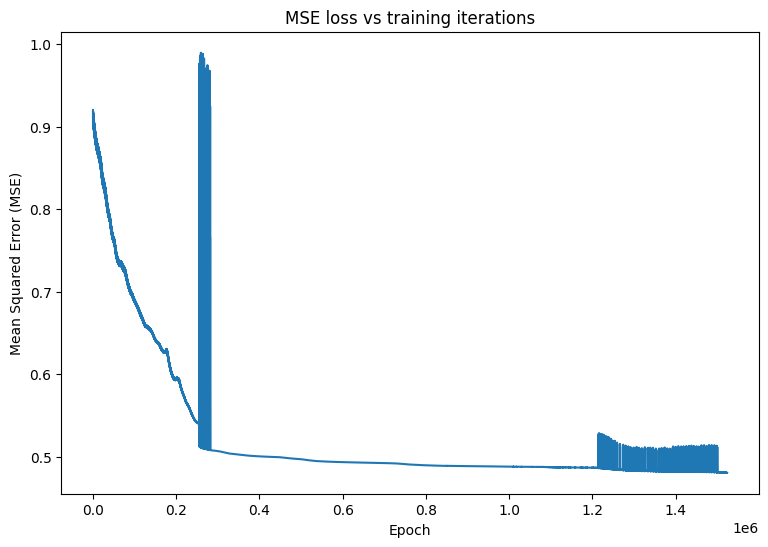

In [146]:
# Plot model results
print("\n")
plt.plot(range(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('MSE loss vs training iterations');

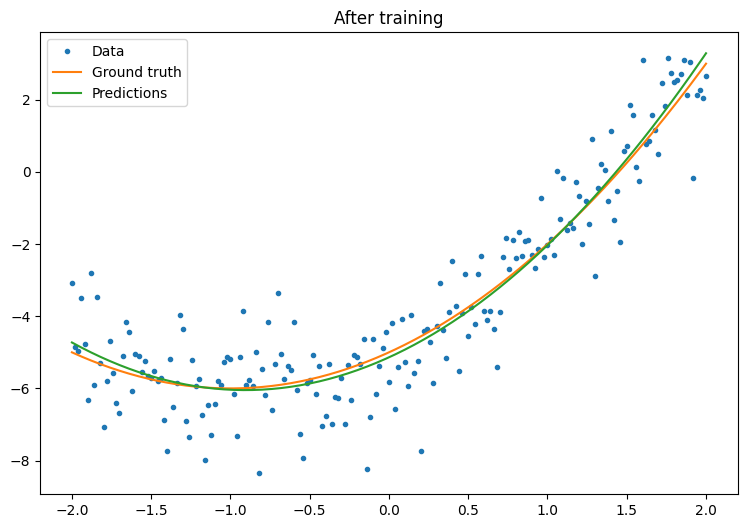

In [42]:
plot_preds(x, y, f, quad_model, 'After training')

In [135]:
save_path="./tensorflow"
tf.saved_model.save(mlmodel, save_path)

INFO:tensorflow:Assets written to: ./tensorflow/assets


In [142]:
model = Model()

In [144]:
model.model.variables

ListWrapper([<tf.Variable 'Variable:0' shape=(32, 9) dtype=float32, numpy=
array([[ -9.863524  , -18.716656  ,  15.705601  , -13.616024  ,
         -5.0061326 ,  12.370011  ,   9.917499  ,  -5.9396834 ,
          7.0328407 ],
       [ -9.865782  ,  20.191462  , -33.327045  ,  -1.1075016 ,
        -39.019615  ,  -1.132385  ,  -6.30093   ,  -7.311744  ,
          3.454783  ],
       [-23.232342  , -22.492683  ,  -4.2745557 , -21.28165   ,
        -34.678875  ,  29.520071  , -28.418745  ,  13.488864  ,
         -2.885906  ],
       [ 10.600892  ,  -4.421362  , -41.355217  ,  12.64366   ,
          9.305536  , -24.325727  ,  -4.512564  , -11.714044  ,
         15.141952  ],
       [ -3.2707205 , -12.774985  , -27.988338  , -12.192141  ,
        -21.05386   ,   8.460428  , -17.028957  ,   4.585246  ,
          5.773456  ],
       [ -0.10873367,   2.5386124 ,   1.4385825 , -26.275368  ,
        -23.04979   ,  10.542871  ,  -5.0493016 , -12.008825  ,
        -18.588408  ],
       [ 18.411514 

In [122]:
mlmodel(tf.constant(one_x)).numpy()

array([[0.12587127]], dtype=float32)

In [118]:
mlmodel.loss(mlmodel(train_x), train_y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5117942>

In [156]:
mlutils.evaluate(ppl.onehot(mlmodel(train_x).numpy()), ppl.onehot(train_y.numpy()))

Won : 951.0
Lost : 426.0
Total : 1377.0
Diff : 525.0
Edge : 38.12636165577342%
IR : 14.147912


0.6906318

In [180]:
mlutils.evaluate(ppl.onehot(tf.nn.sigmoid(mlmodel(train_x)).numpy()), ppl.onehot(train_y.numpy()), threshold=0.5)

Won : 1033.0
Lost : 344.0
Total : 1377.0
Diff : 689.0
Edge : 50.03631082062454%
IR : 18.56745


0.75018156

In [158]:
mlutils.evaluate(ppl.onehot(np.array([[1]]*len(train_y))), ppl.onehot(train_y.numpy()))

Won : 709.0
Lost : 668.0
Total : 1377.0
Diff : 41.0
Edge : 2.9774872912127814%
IR : 1.1048845


0.51488745

In [159]:
mlutils.evaluate(ppl.onehot(tf.nn.sigmoid(mlmodel(train2_x)).numpy()), ppl.onehot(train2_y.numpy()))

Won : 788.0
Lost : 590.0
Total : 1378.0
Diff : 198.0
Edge : 14.368650217706822%
IR : 5.3338475


0.57184327

In [160]:
mlutils.evaluate(ppl.onehot(np.array([[1]]*len(train2_y))), ppl.onehot(train2_y.numpy()))

Won : 726.0
Lost : 652.0
Total : 1378.0
Diff : 74.0
Edge : 5.370101596516691%
IR : 1.9934582


0.5268505

In [161]:
mlutils.evaluate(ppl.onehot(np.array([[1]]*len(test_y))), ppl.onehot(test_y.numpy()))

Won : 45.0
Lost : 57.0
Total : 102.0
Diff : -12.0
Edge : -11.764705882352942%
IR : -1.188177


0.44117647

In [175]:
mlutils.evaluate(ppl.onehot(tf.nn.sigmoid(mlmodel(test_x)).numpy()), ppl.onehot(test_y.numpy()), threshold=0.8)

Won : 33.0
Lost : 17.0
Total : 50.0
Diff : 16.0
Edge : 32.0%
IR : 2.2627416


0.66

In [190]:
call_sig = mlmodel.call.get_concrete_function(tf.TensorSpec([None,None], tf.float32))
predict_sig = mlmodel.predictions.get_concrete_function(tf.TensorSpec([None,None], tf.float32))
signatures = {"serving_default": call_sig,  "predictions": predict_sig}

In [243]:
tf.saved_model.save(mlmodel, "../config/modelserver/mlmodel/3", signatures=signatures)


INFO:tensorflow:Assets written to: ../config/modelserver/mlmodel/3/assets


In [179]:
mlmodel([[0.39066112, 0.82616735, 0.1997226 , 0.5085529 , 0.50392973, 1.0, 0.0, 0.6292187 , 0.16230647]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.2721312]], dtype=float32)>

In [182]:
tf.nn.sigmoid(mlmodel([[0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9999579]], dtype=float32)>

In [183]:
mlmodel

In [184]:
@tf.function(input_signature=[tf.TensorSpec([None, None], tf.float32)])
def predictions(self, x):
    return tf.nn.sigmoid(self(x))

In [186]:
MLModel.predictions = predictions

In [187]:
mlmodel.predictions(train_x)

<tf.Tensor: shape=(1377, 1), dtype=float32, numpy=
array([[0.56761605],
       [0.4531588 ],
       [0.56187314],
       ...,
       [0.5438341 ],
       [0.57907546],
       [0.5562006 ]], dtype=float32)>

In [195]:
mlmodel.predictions(one_x)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.56761605]], dtype=float32)>

In [194]:
mlmodel.variables

[<tf.Variable 'Variable:0' shape=(32, 9) dtype=float32, numpy=
 array([[-1.44841785e+01, -1.80242386e+01,  2.26633034e+01,
         -1.68634968e+01, -4.52940989e+00,  1.28293257e+01,
          1.15039520e+01, -7.93834400e+00,  1.04560423e+01],
        [-1.17877569e+01,  2.02840137e+01, -3.08868923e+01,
          1.32175195e+00, -4.62234039e+01,  2.63368394e-02,
         -3.58606458e+00, -7.87929630e+00,  7.13431978e+00],
        [-2.91052437e+01, -1.10273781e+01, -9.18012333e+00,
         -7.11220551e+00, -5.11521568e+01,  2.56463203e+01,
         -3.62739716e+01,  1.47334995e+01, -2.61382103e+00],
        [ 1.29355679e+01, -3.42680120e+00, -4.85930138e+01,
          1.33533487e+01,  1.12640285e+01, -2.82029705e+01,
         -8.29335594e+00, -1.74125328e+01,  1.75305901e+01],
        [-6.20597124e-01, -1.49074268e+01, -2.26762428e+01,
         -6.52964401e+00, -2.16435699e+01,  9.99973583e+00,
         -1.90522614e+01,  2.39050627e+00,  5.39121485e+00],
        [-6.31576252e+00,  3.884

In [198]:
mlutils.evaluate(ppl.onehot(mlmodel.predictions(test_x).numpy()), ppl.onehot(test_y.numpy()), threshold=0.8)

Won : 33.0
Lost : 17.0
Total : 50.0
Diff : 16.0
Edge : 32.0%
IR : 2.2627416


0.66

In [241]:
getPredictionSignals(ppl.onehot(mlmodel.predictions(test_x).numpy()), threshold=0.7)

array([ 0.,  0., -1.,  0., -1.,  0., -1.,  0.,  1.,  0.,  0., -1.,  1.,
        0.,  0., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., -1.,
        0.,  0.,  1.,  0.,  0., -1., -1., -1.,  0.,  0.,  0.,  1.,  0.,
        1.,  0.,  0.,  0.,  0., -1.,  0., -1.,  0.,  1., -1.,  0.,  0.,
        0., -1.,  1.,  0., -1.,  0., -1., -1., -1., -1.,  1.,  0.,  0.,
        1.,  0.,  0.,  1.,  0.,  0., -1.,  1., -1.,  1.,  0.,  0.,  0.,
       -1.,  0., -1.,  0., -1., -1.,  0., -1., -1., -1.,  1.,  1.,  1.,
        1., -1.,  1., -1., -1., -1.,  1.,  1., -1.,  1.,  0.])

In [238]:
def getPredictionSignals(predictions, threshold=0):
    signals = np.ones(len(predictions))
    a = np.argmax(predictions, axis=1)
    signals[(a == 1)] = -1  # Set any DOWN signals to -1 (UP signals will pick up the default of 1)
    # Implement a threshold AND ensure any 0-values predictions results in a 0 signal
    signals[(predictions <= threshold).all(axis=1)] = 0
    return signals

In [224]:
ppl.onehot(mlmodel.predictions(test_x).numpy())

array([[6.08195901e-01, 3.91804099e-01],
       [5.71965575e-01, 4.28034425e-01],
       [1.67006385e-02, 9.83299375e-01],
       [5.72751105e-01, 4.27248895e-01],
       [4.99593979e-03, 9.95004058e-01],
       [6.85923517e-01, 3.14076483e-01],
       [2.89808452e-01, 7.10191548e-01],
       [5.73930740e-01, 4.26069260e-01],
       [9.49267626e-01, 5.07323742e-02],
       [5.60652554e-01, 4.39347446e-01],
       [5.23707271e-01, 4.76292729e-01],
       [6.47813431e-05, 9.99935210e-01],
       [9.42306936e-01, 5.76930642e-02],
       [5.72800696e-01, 4.27199304e-01],
       [5.72725475e-01, 4.27274525e-01],
       [1.34209141e-01, 8.65790844e-01],
       [5.80510437e-01, 4.19489563e-01],
       [5.92342615e-01, 4.07657385e-01],
       [5.65487981e-01, 4.34512019e-01],
       [9.99999940e-01, 5.96046448e-08],
       [5.64256489e-01, 4.35743511e-01],
       [5.70837617e-01, 4.29162383e-01],
       [4.32379842e-01, 5.67620158e-01],
       [6.75249159e-01, 3.24750841e-01],
       [5.716509

In [242]:
mlutils.evaluate(ppl.onehot(tf.nn.sigmoid(mlmodel(train_x)).numpy()), ppl.onehot(train_y.numpy()), threshold=0.5)

Won : 1033.0
Lost : 344.0
Total : 1377.0
Diff : 689.0
Edge : 50.03631082062454%
IR : 18.56745


0.75018156